In [1]:
#import all the libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy.stats as scs
import yfinance as yf  #the stock data from Yahoo Finance
import matplotlib.pyplot as plt #set the parameters for plotting
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'


df = yf.download('AAPL',
                 start = '1999-12-31',
                 end= '2010-12-31') #download Apple stock price
d1 = pd.DataFrame(df['Adj Close'])#create a df with only stock price
d1.rename(columns={'Adj Close':'adj_close'}, inplace=True)
d1['simple_rtn']=d1.adj_close.pct_change()#percentage return
d1['log_rtn'] = np.log(d1.adj_close/d1.adj_close.shift(1))
#log return with 1 day lag
d1.head()

[*********************100%***********************]  1 of 1 completed


,adj_close,simple_rtn,log_rtn
Date,,,
1999-12-31,0.781300,NaN,NaN
2000-01-03,0.850643,0.088754,0.085033
2000-01-04,0.778926,-0.084310,-0.088077
2000-01-05,0.790324,0.014633,0.014527
2000-01-06,0.721930,-0.086538,-0.090514


In [2]:
n_sigmas=2

#get mean and std
mu = d1.describe().loc['mean', 'log_rtn']
sigma = d1.describe().loc['std', 'log_rtn']
condition = (d1['log_rtn'] > mu + sigma * n_sigmas) | (d1['log_rtn'] < mu - sigma * n_sigmas) #set the condition to be 2 times of std around mean
d1['outliers'] = np.where(condition, 1, 0)#like an if, else 
d1.head()

,adj_close,simple_rtn,log_rtn,outliers
Date,,,,
1999-12-31,0.781300,NaN,NaN,0
2000-01-03,0.850643,0.088754,0.085033,1
2000-01-04,0.778926,-0.084310,-0.088077,1
2000-01-05,0.790324,0.014633,0.014527,0
2000-01-06,0.721930,-0.086538,-0.090514,1


In [3]:
#using pd's bool selection to remove outliers
d1_removed_outliers = d1.loc[d1['outliers'] == 0].iloc[:, :-1]
d1_removed_outliers.head()

,adj_close,simple_rtn,log_rtn
Date,,,
1999-12-31,0.781300,NaN,NaN
2000-01-05,0.790324,0.014633,0.014527
2000-01-07,0.756127,0.047369,0.046281
2000-01-10,0.742829,-0.017588,-0.017744
2000-01-11,0.704832,-0.051151,-0.052506


In [4]:
d1_removed_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2669 entries, 1999-12-31 to 2010-12-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   adj_close   2669 non-null   float64
 1   simple_rtn  2668 non-null   float64
 2   log_rtn     2668 non-null   float64
dtypes: float64(3)
memory usage: 83.4 KB


In [5]:
d1 = d1_removed_outliers

In [6]:
#calculate the pearson correlation
corr = d1[['simple_rtn', 'log_rtn']].corr()
corr

,simple_rtn,log_rtn
simple_rtn,1.000000,0.999853
log_rtn,0.999853,1.000000


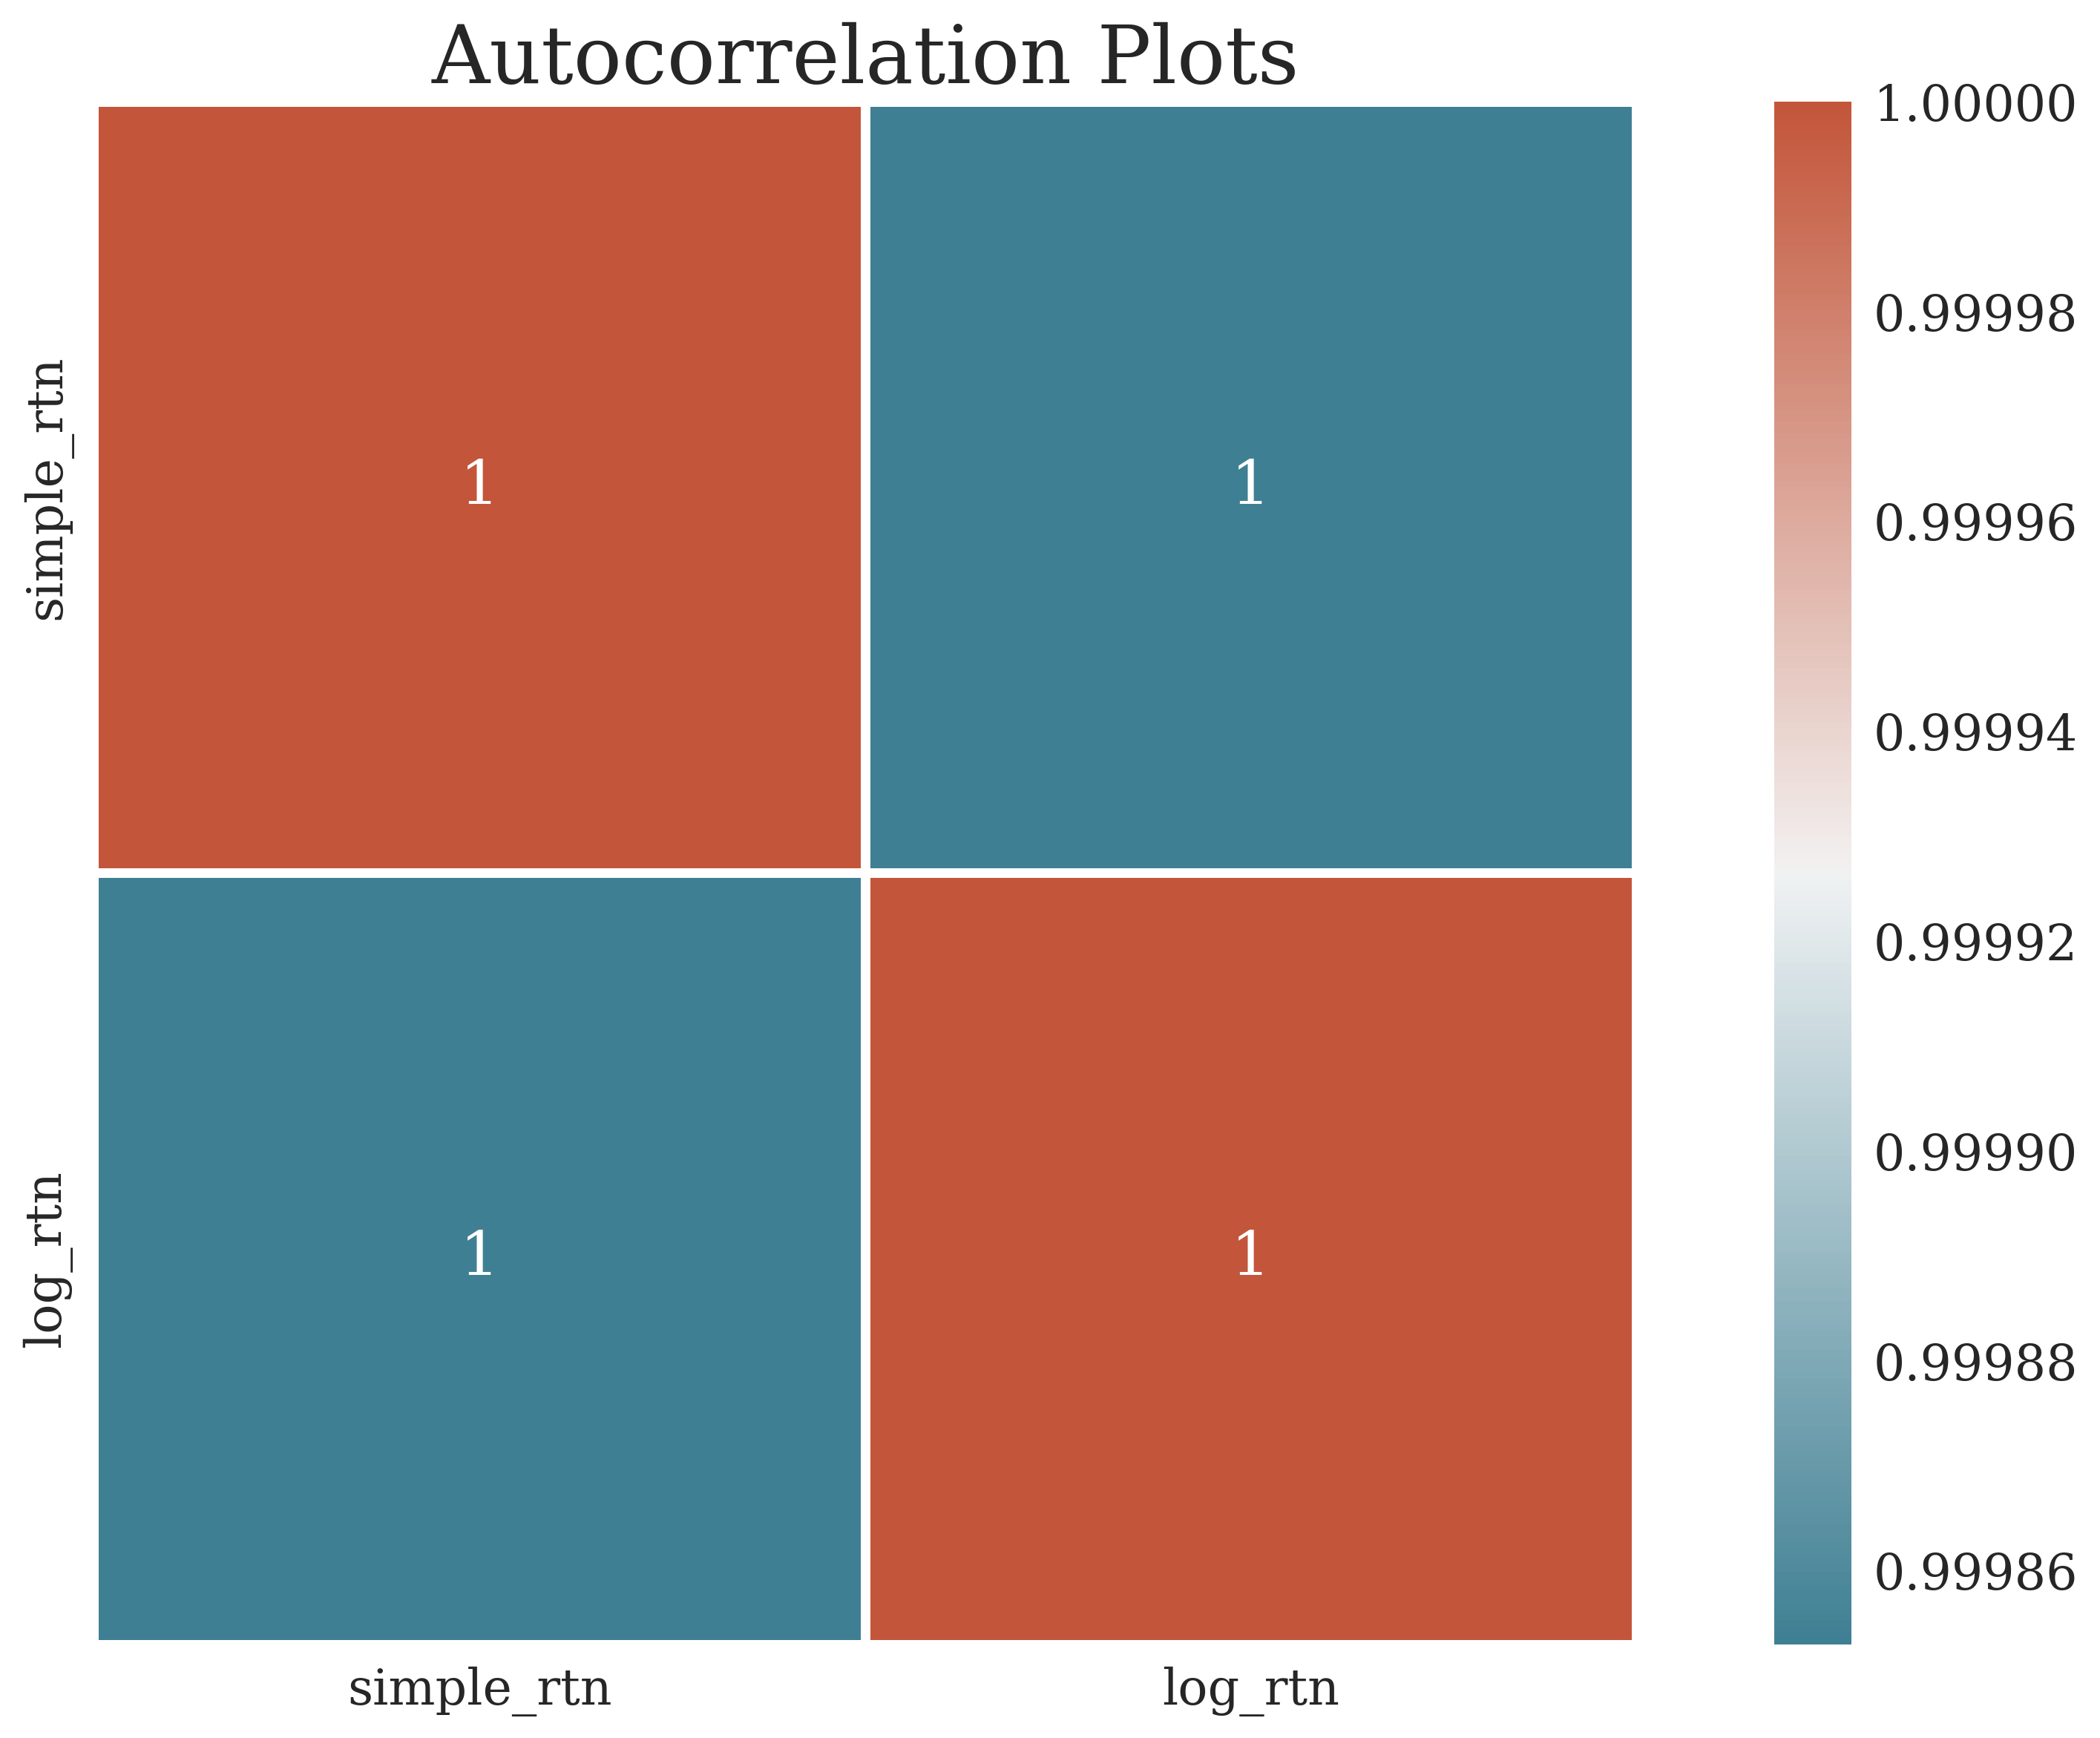

In [7]:
#draw heatmap with seaborne
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr, annot=True, cmap=cmap,
                 square=True, linewidths=3,
                 linecolor='w')
ax.set_title('Autocorrelation Plots', fontsize=26)
sns.set(font_scale=2);

In [8]:
d1.describe().round(4)

,adj_close,simple_rtn,log_rtn
count,2669.0000,2668.0000,2668.0000
mean,2.4267,0.0015,0.0012
std,2.4745,0.0242,0.0242
min,0.1994,-0.0619,-0.0639
25%,0.3497,-0.0135,-0.0136
50%,1.3437,0.0010,0.0010
75%,3.9519,0.0164,0.0162
max,9.8933,0.0678,0.0656


In [9]:
#extract all the stats from describe() function
def extract_data_stats(col):
    d_stat = col.describe()
    mu = d_stat['mean']
    sigma = d_stat['std']
    rtn_range = np.linspace(d_stat['min'], d_stat['max'], num=1000)
    norm_pdf = scs.norm.pdf(rtn_range, loc=mu, scale=sigma)
    
    return mu, sigma, rtn_range, norm_pdf

In [10]:
def draw_hist(col, xlim=(-0.2, 0.2)):
    mu, sigma, rtn_range, norm_pdf = extract_data_stats(col)
    sns.histplot(col, kde=True, stat='density', label='Hist')
    plt.plot(rtn_range, norm_pdf, 'r', lw=3, 
             label=f'N({mu:.3f}, {sigma**2:.4f})')
    plt.axvline(x=0, c='c',linestyle='--', lw=3)
    plt.title(f'Distribution of {col.name}', fontsize=24)
    plt.xlim(xlim)
    plt.legend(loc='upper right', fontsize=20, 
               frameon=True,fancybox=True, 
               framealpha=1, shadow=True, borderpad=1);

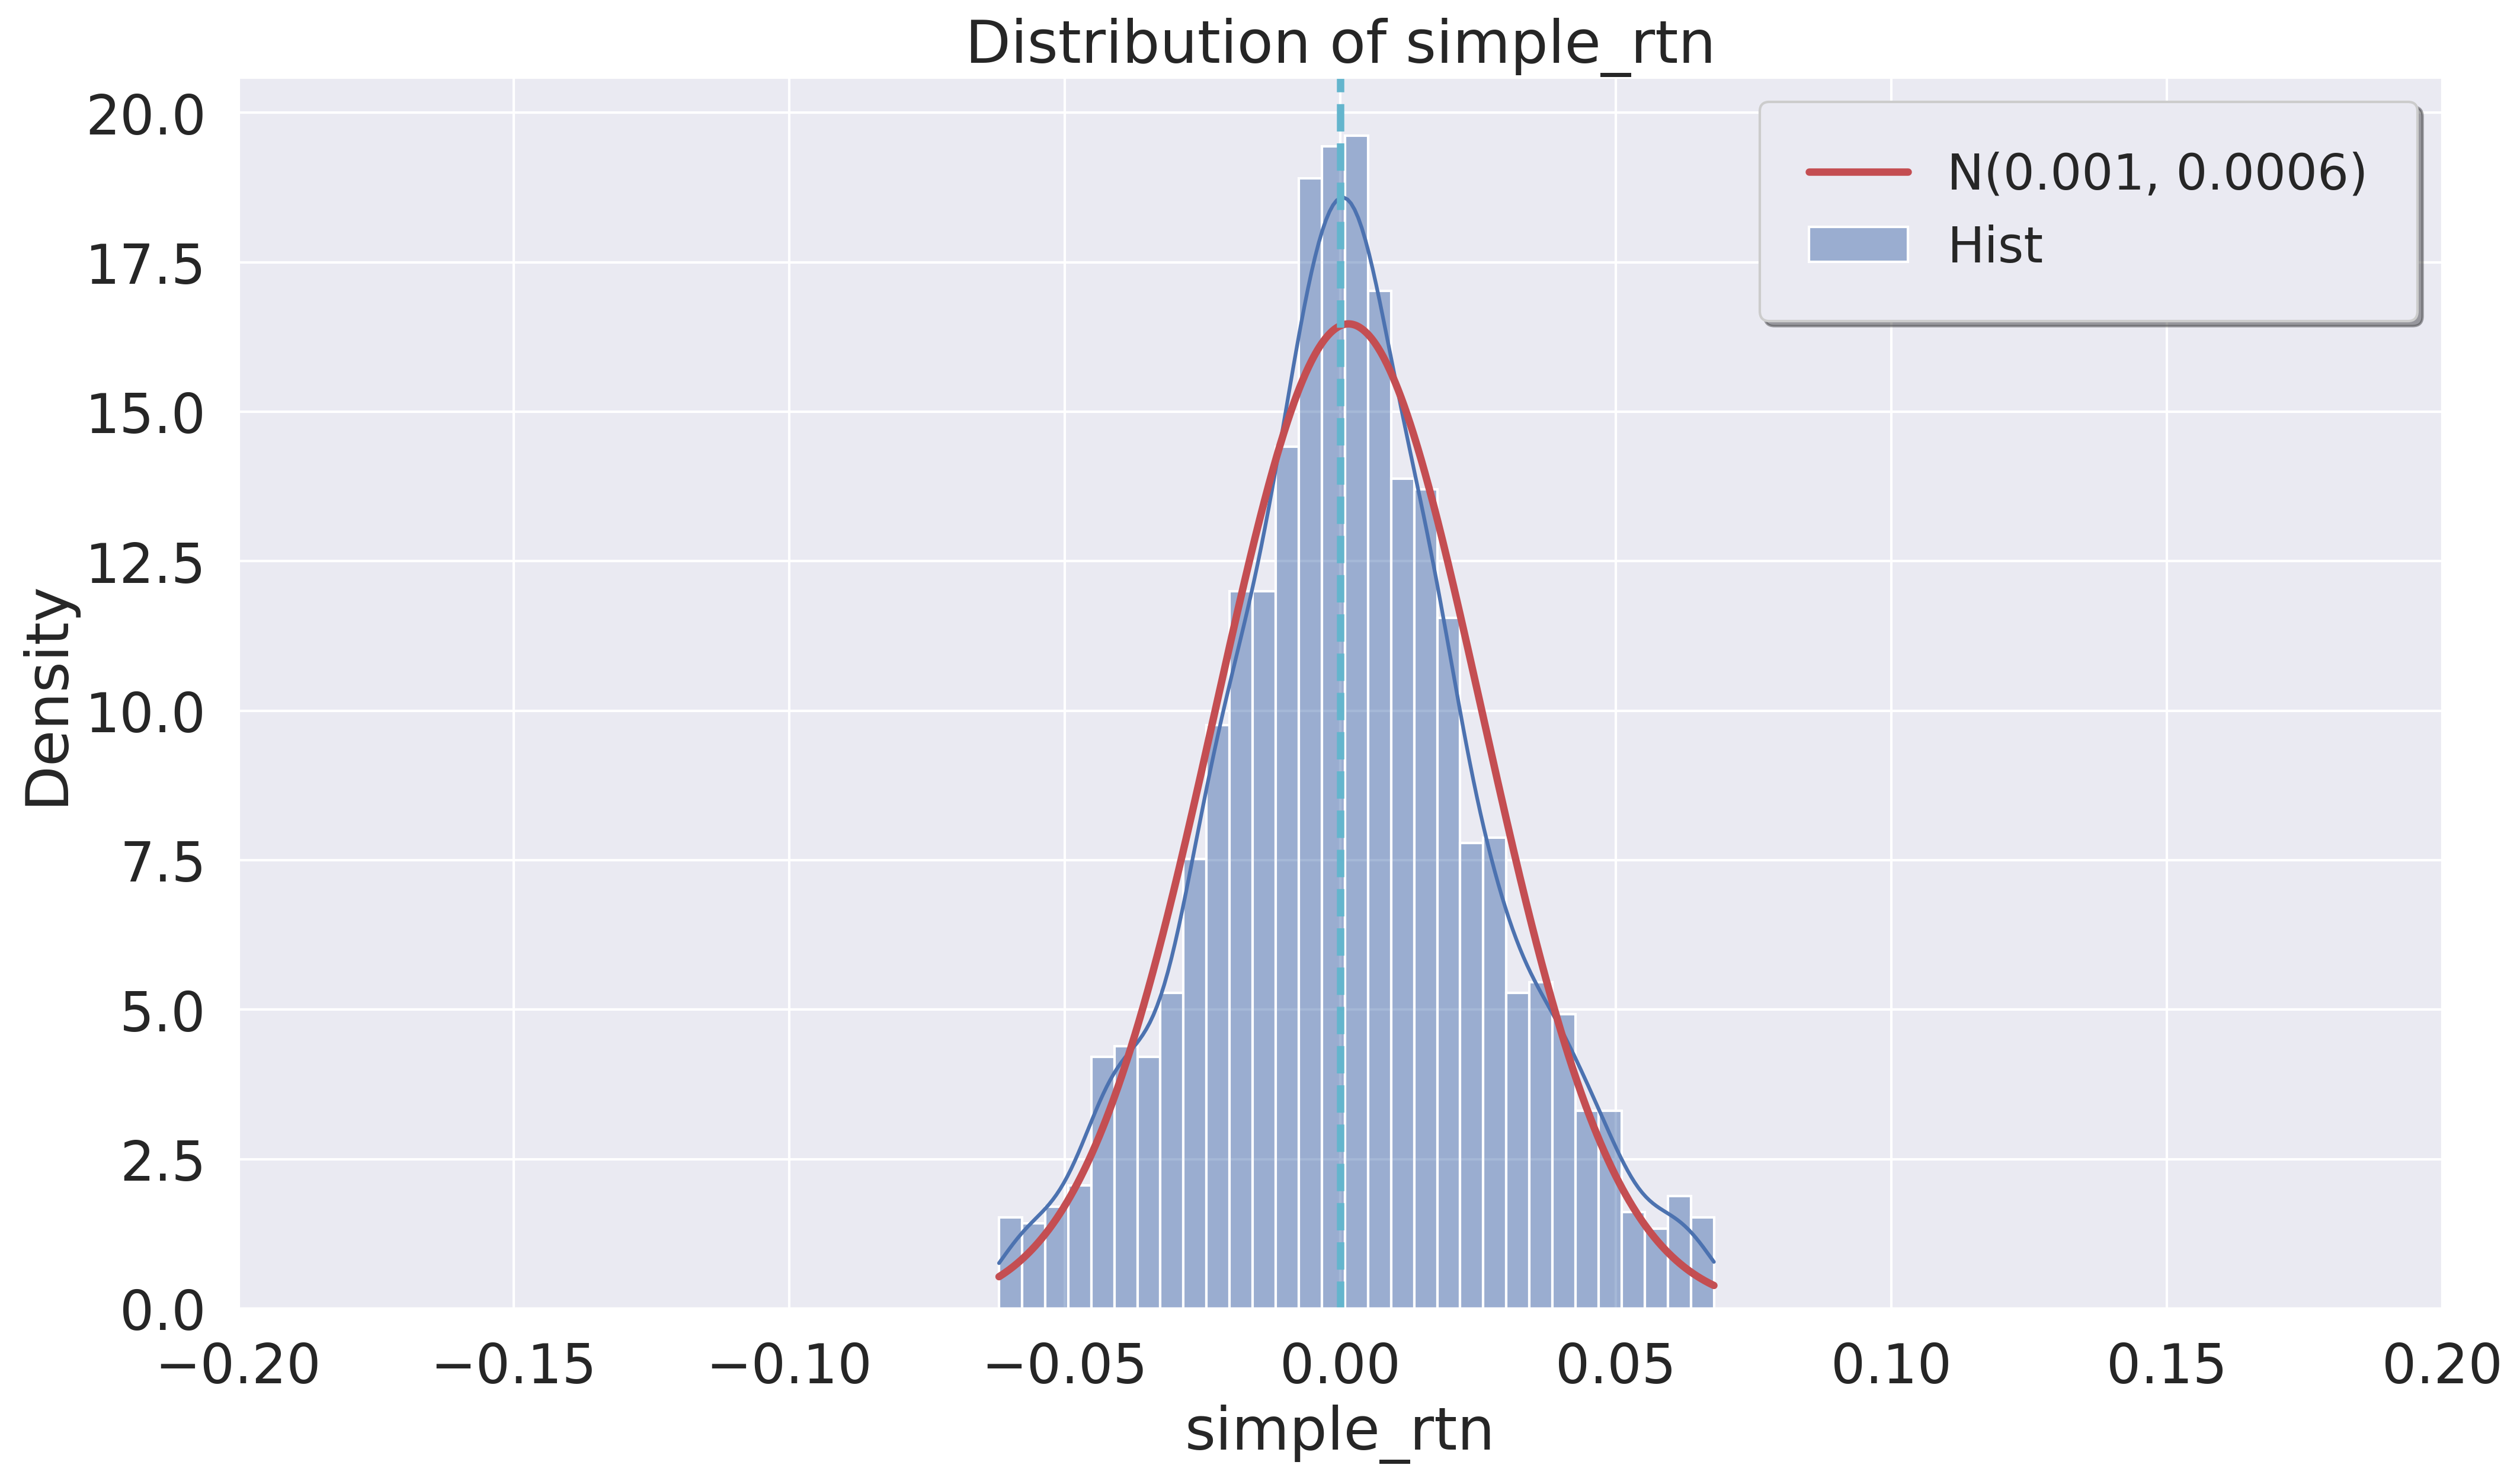

In [11]:
draw_hist(d1.simple_rtn)

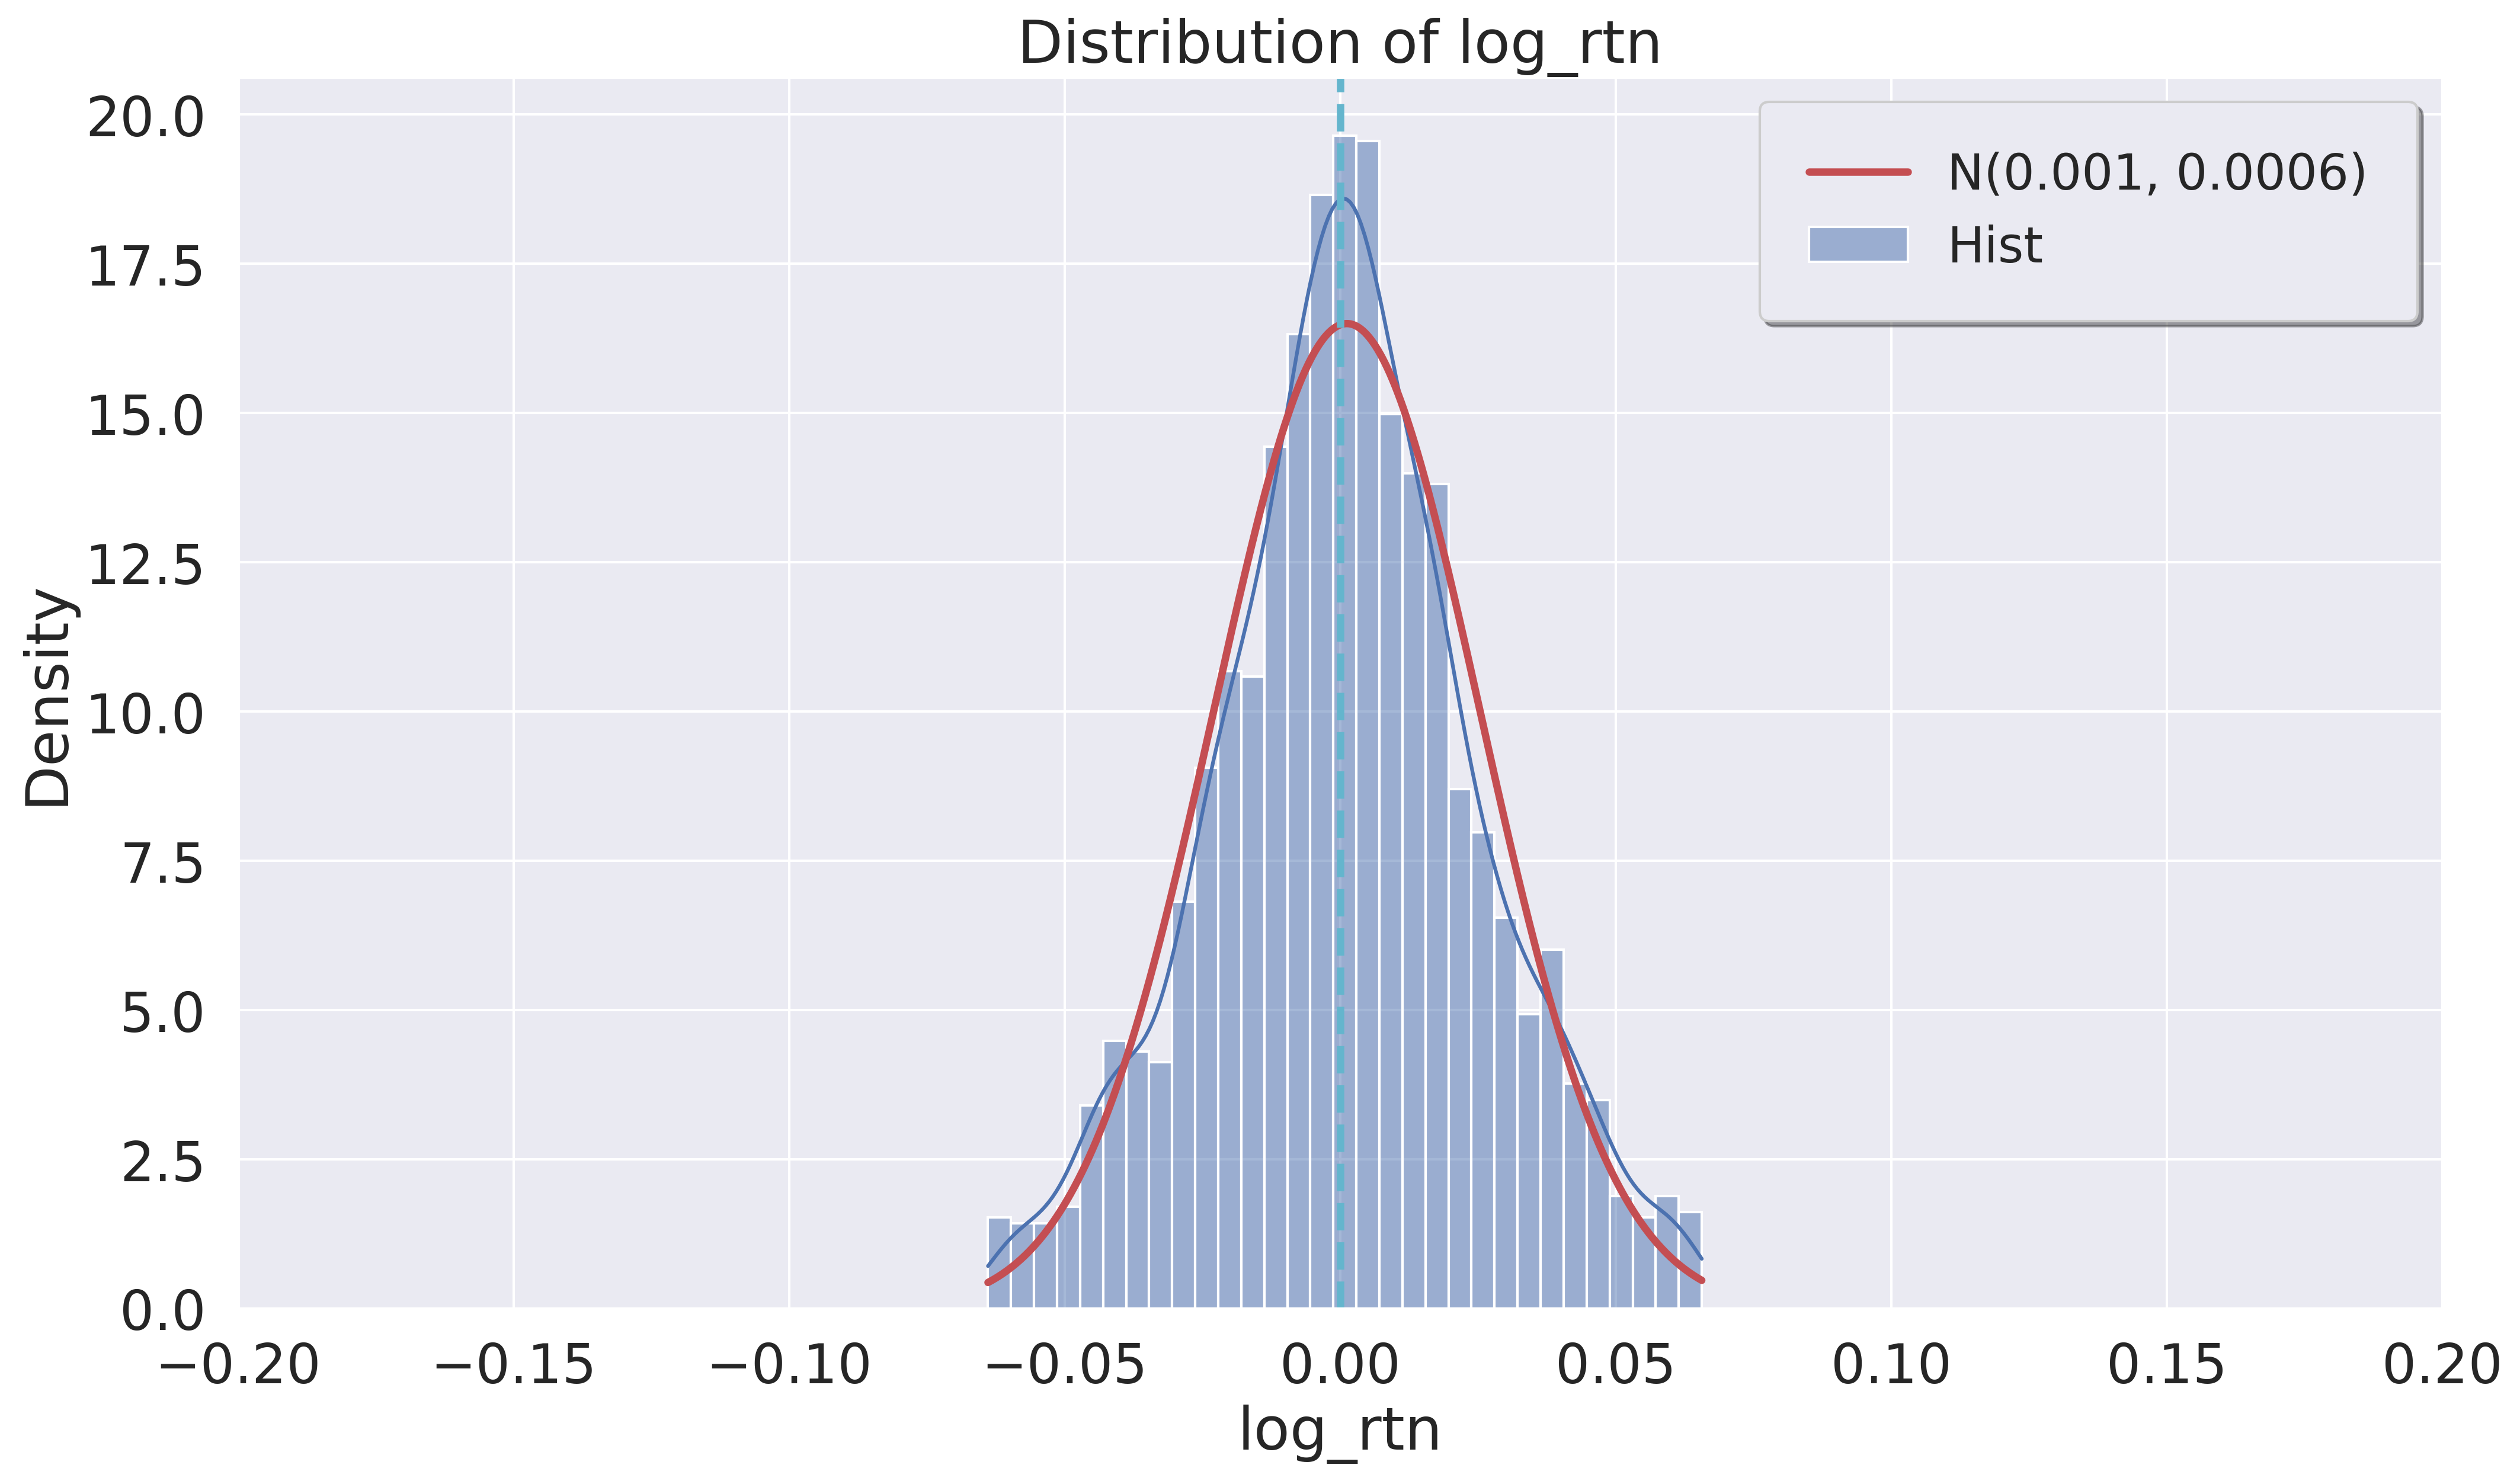

In [12]:
draw_hist(d1.log_rtn)

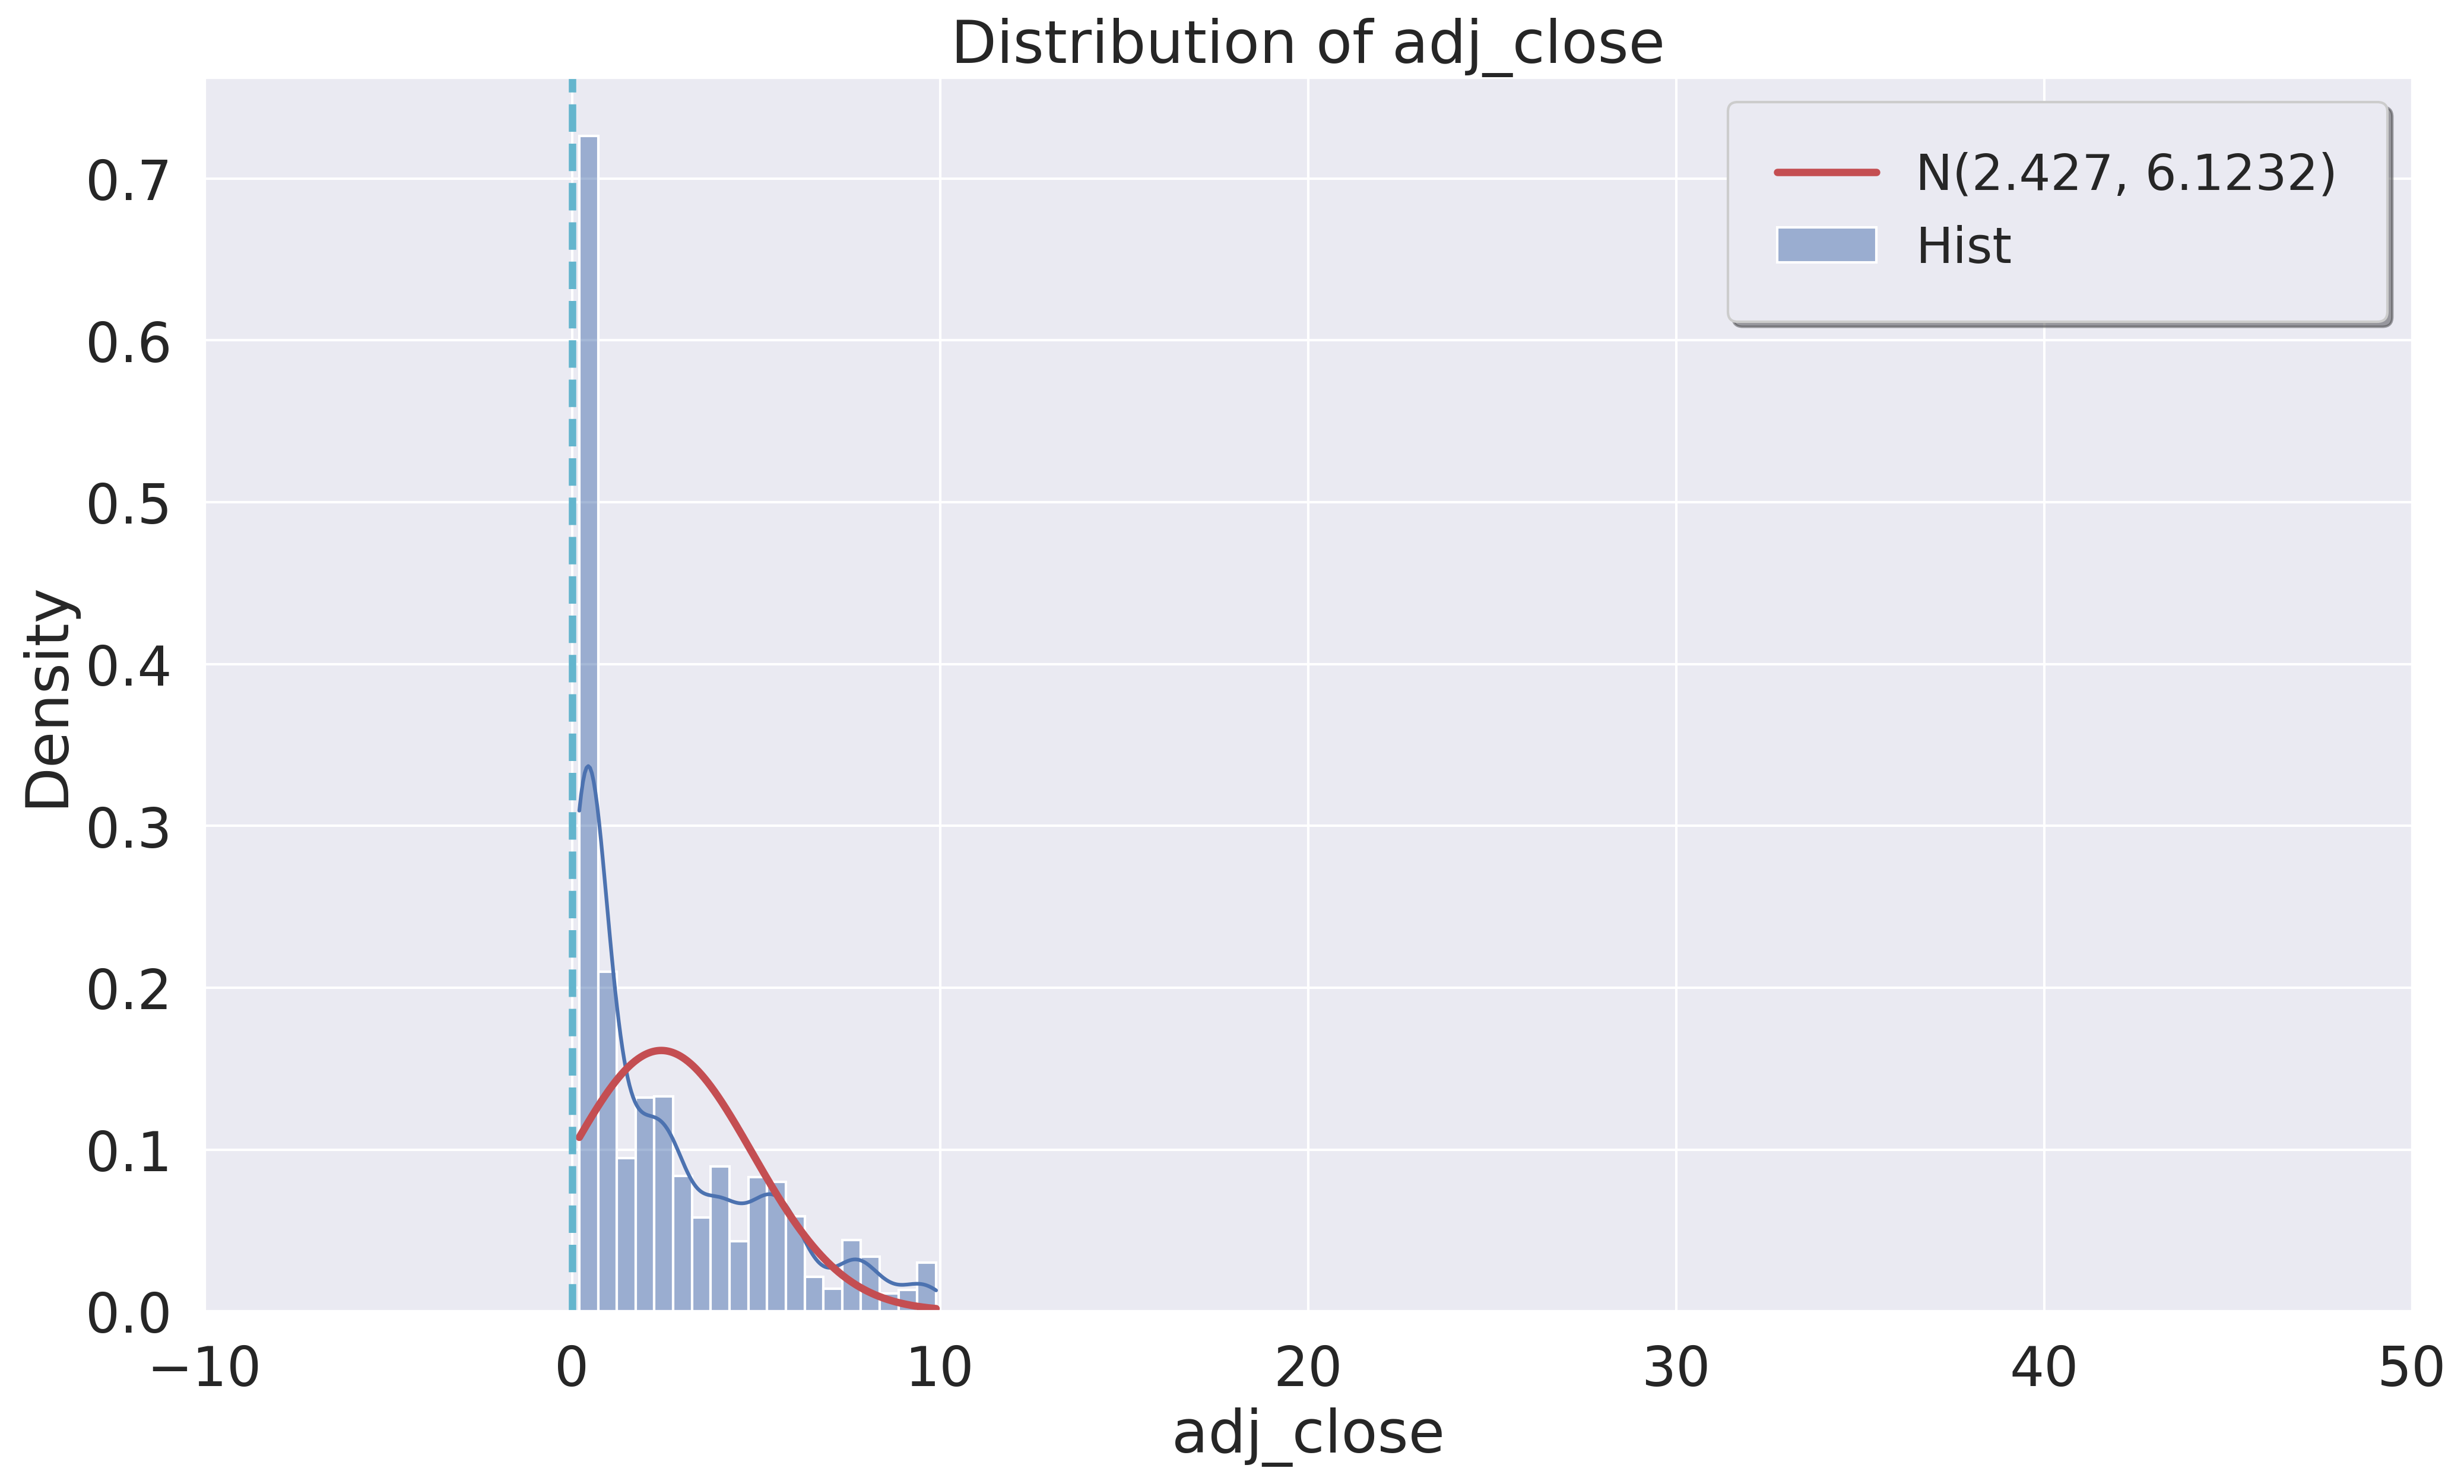

In [13]:
draw_hist(d1.adj_close,xlim=(-10,50))

In [14]:
#get 5 days lagged return by a for loop
df_simple_rtn = pd.DataFrame(d1['adj_close'])
lags = 5
for lag in range(1, lags+1):
    col = f'lag_{lag}_simple_rtn'
    df_simple_rtn[col] = df_simple_rtn['adj_close']. \
                         pct_change(periods=lag)
    
df_simple_rtn.dropna(inplace=True)
df_simple_rtn.head()

,adj_close,lag_1_simple_rtn,lag_2_simple_rtn,lag_3_simple_rtn,lag_4_simple_rtn,lag_5_simple_rtn
Date,,,,,,
2000-01-12,0.662562,-0.059973,-0.108056,-0.123743,-0.161658,-0.151976
2000-01-14,0.763251,0.151970,0.082884,0.027493,0.009422,-0.034255
2000-01-18,0.789849,0.034847,0.192114,0.120619,0.063299,0.044598
2000-01-19,0.809797,0.025256,0.060984,0.222222,0.148922,0.090154
2000-01-20,0.862518,0.065103,0.092003,0.130057,0.301792,0.223720


In [15]:
#get 5 days lagged return by a for loop
df_log_rtn = pd.DataFrame(d1['adj_close'])
lags = 5
for lag in range(1, lags+1):
    col = f'lag_{lag}_log_rtn'
    df_log_rtn[col] = np.log(df_log_rtn['adj_close']/\
    df_log_rtn['adj_close'].shift(lag))
    
                
df_log_rtn.dropna(inplace=True)
df_log_rtn.head()

,adj_close,lag_1_log_rtn,lag_2_log_rtn,lag_3_log_rtn,lag_4_log_rtn,lag_5_log_rtn
Date,,,,,,
2000-01-12,0.662562,-0.061846,-0.114352,-0.132096,-0.176329,-0.164846
2000-01-14,0.763251,0.141474,0.079628,0.027122,0.009378,-0.034855
2000-01-18,0.789849,0.034254,0.175728,0.113882,0.061376,0.043632
2000-01-19,0.809797,0.024943,0.059197,0.200670,0.138824,0.086319
2000-01-20,0.862518,0.063071,0.088014,0.122268,0.263742,0.201896


In [16]:
# using ax to draw multi-grahps
def draw_hist_multi(col, xlim=(-0.2, 0.2), ax=None):
    mu, sigma, rtn_range, norm_pdf = extract_data_stats(col)
    sns.histplot(col, kde=True, stat="density", label='Hist', ax=ax)
    sns.kdeplot(col, color='r', lw=3, label=f'N({mu:.3f}, {sigma**2:.4f})', ax=ax)
    ax.axvline(x=0, c='c', linestyle='--', lw=3)
    # adj_close x axis range is wider 
    if (col.name == 'adj_close'):
        ax.set_xlim(-10, 50)
    else:
        ax.set_xlim(xlim)
    ax.legend(loc='upper right', fontsize=8, frameon=True, fancybox=True);

In [17]:
#create subplots figure with each plot drawed by draw_hist_multi() 
def draw_hist_subplots(df):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
    fig.subplots_adjust(hspace = .5) #wspace=.001
    fig.suptitle('Distribution of returns with increased time scale', fontsize=24)
                
    axs = axs.ravel()
    for i, col in enumerate(df.columns):
        draw_hist_multi(df[col], ax=axs[i])

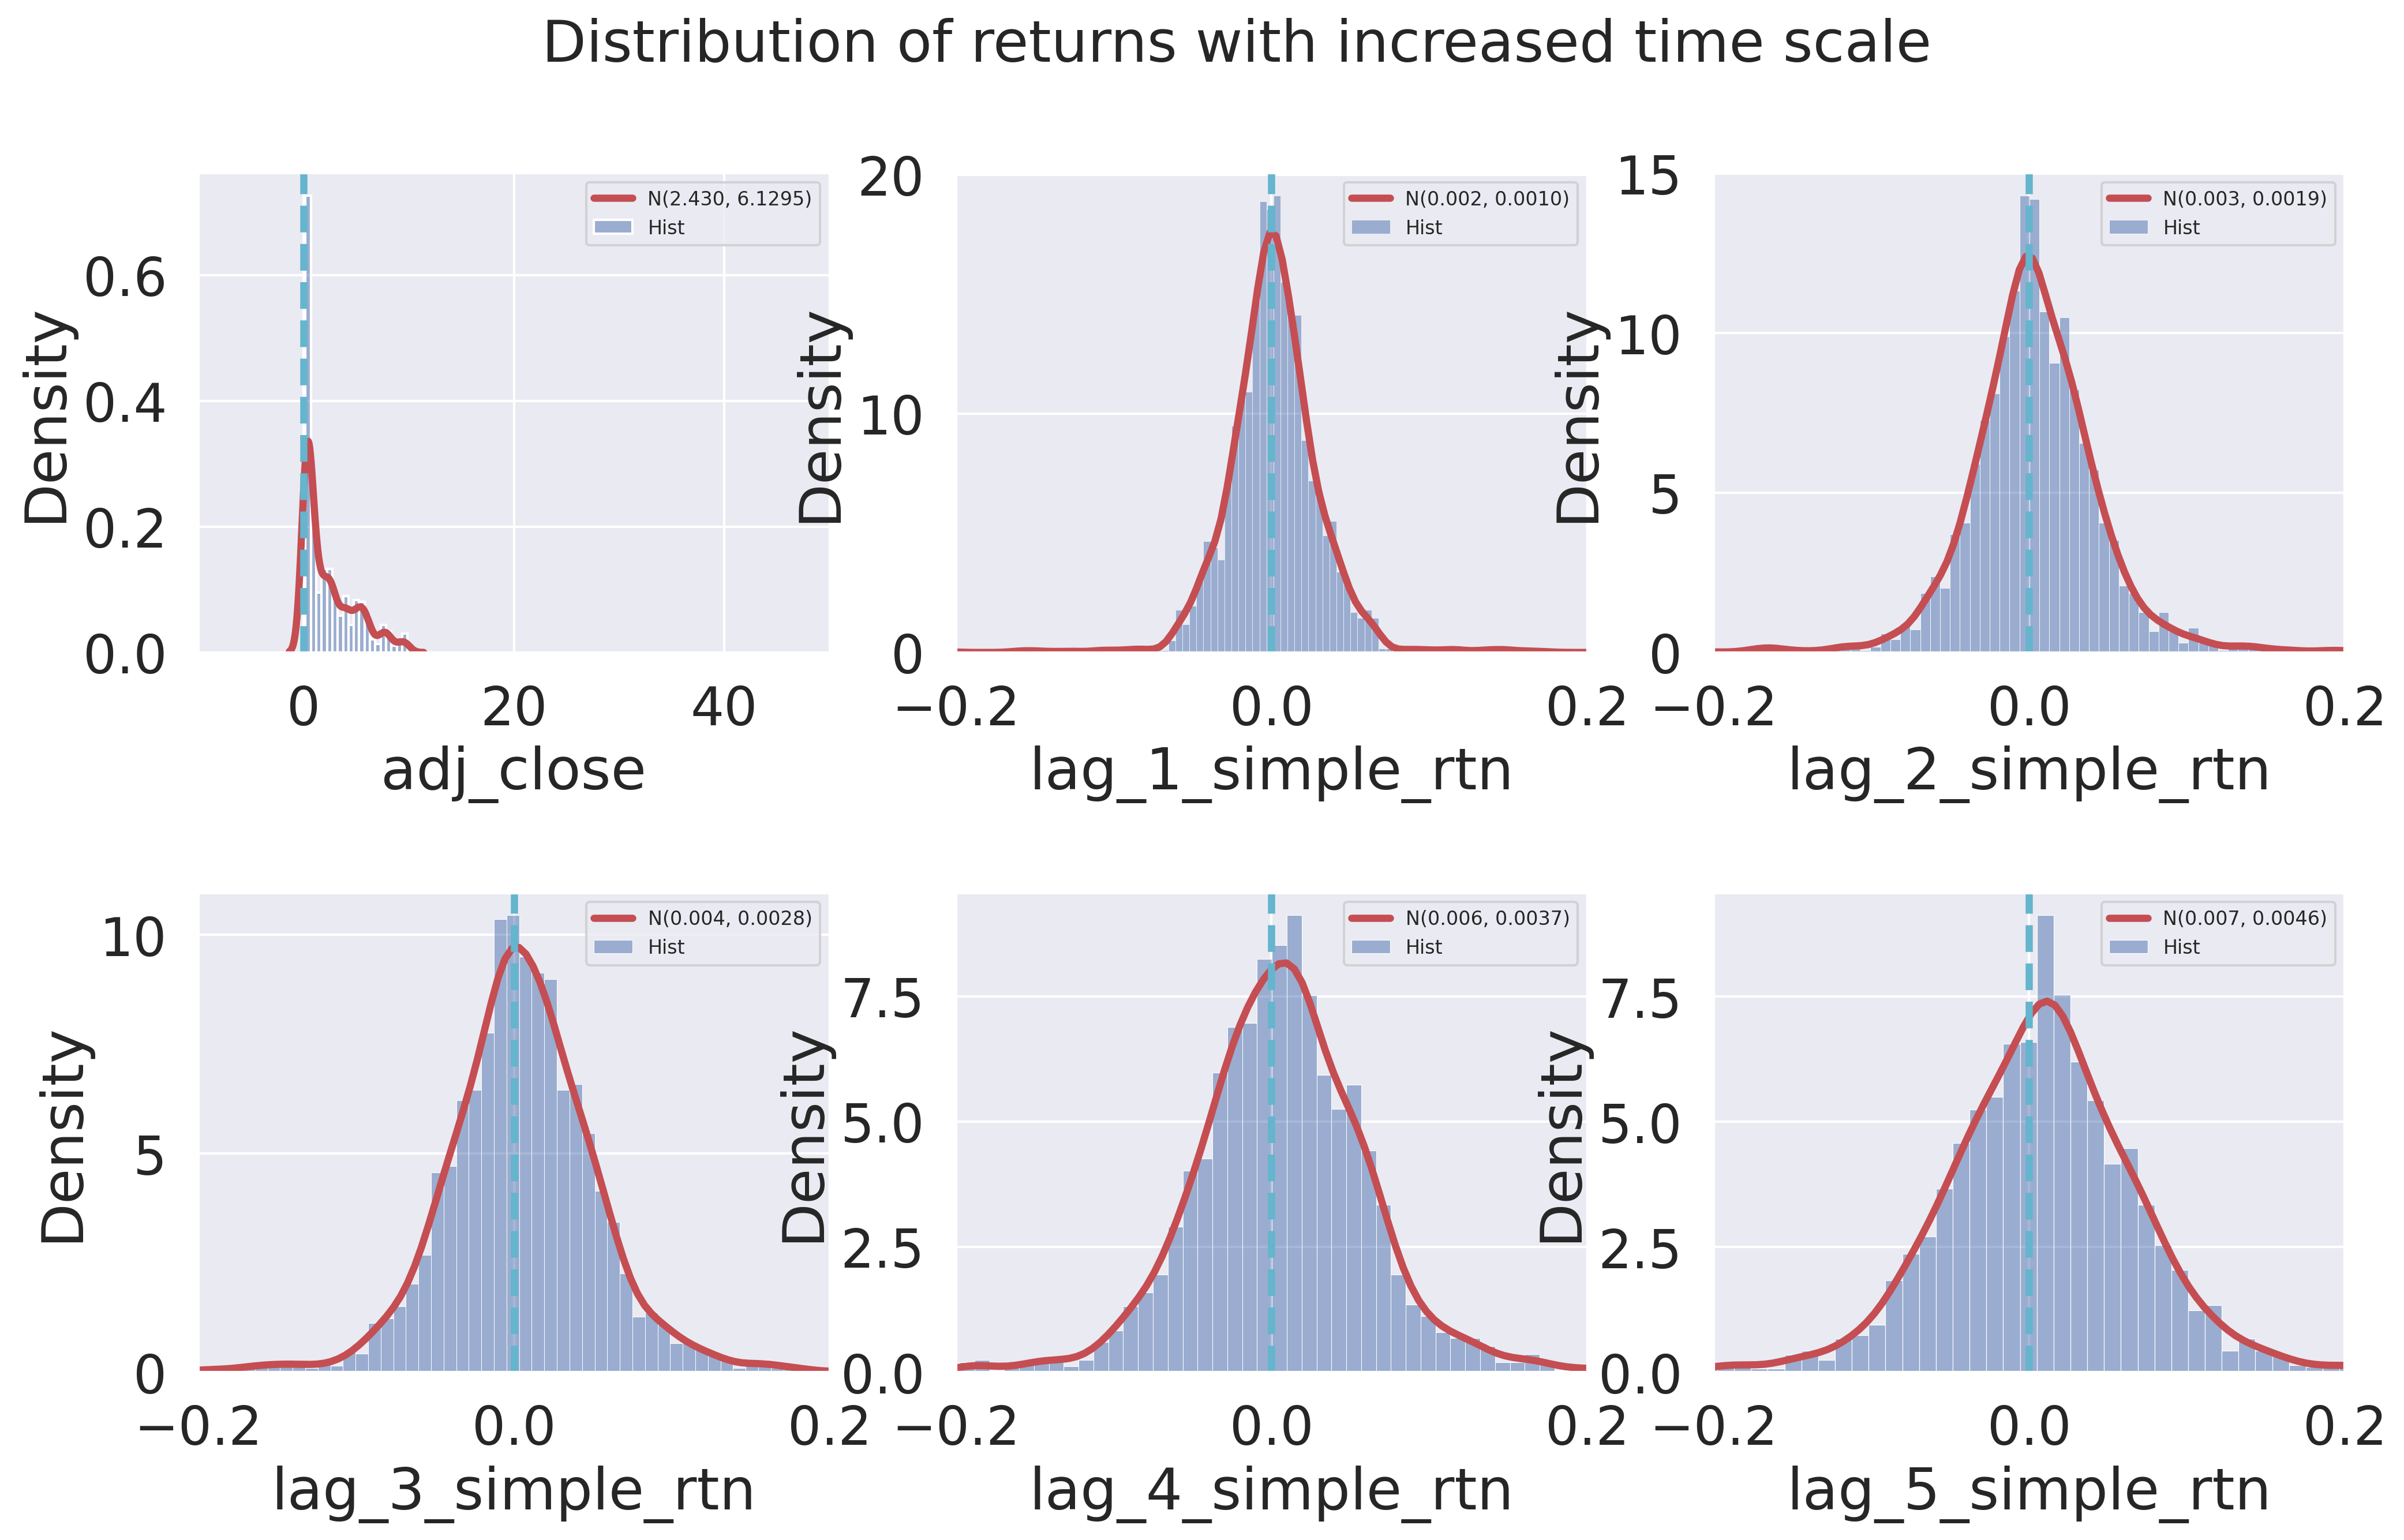

In [18]:
draw_hist_subplots(df_simple_rtn)

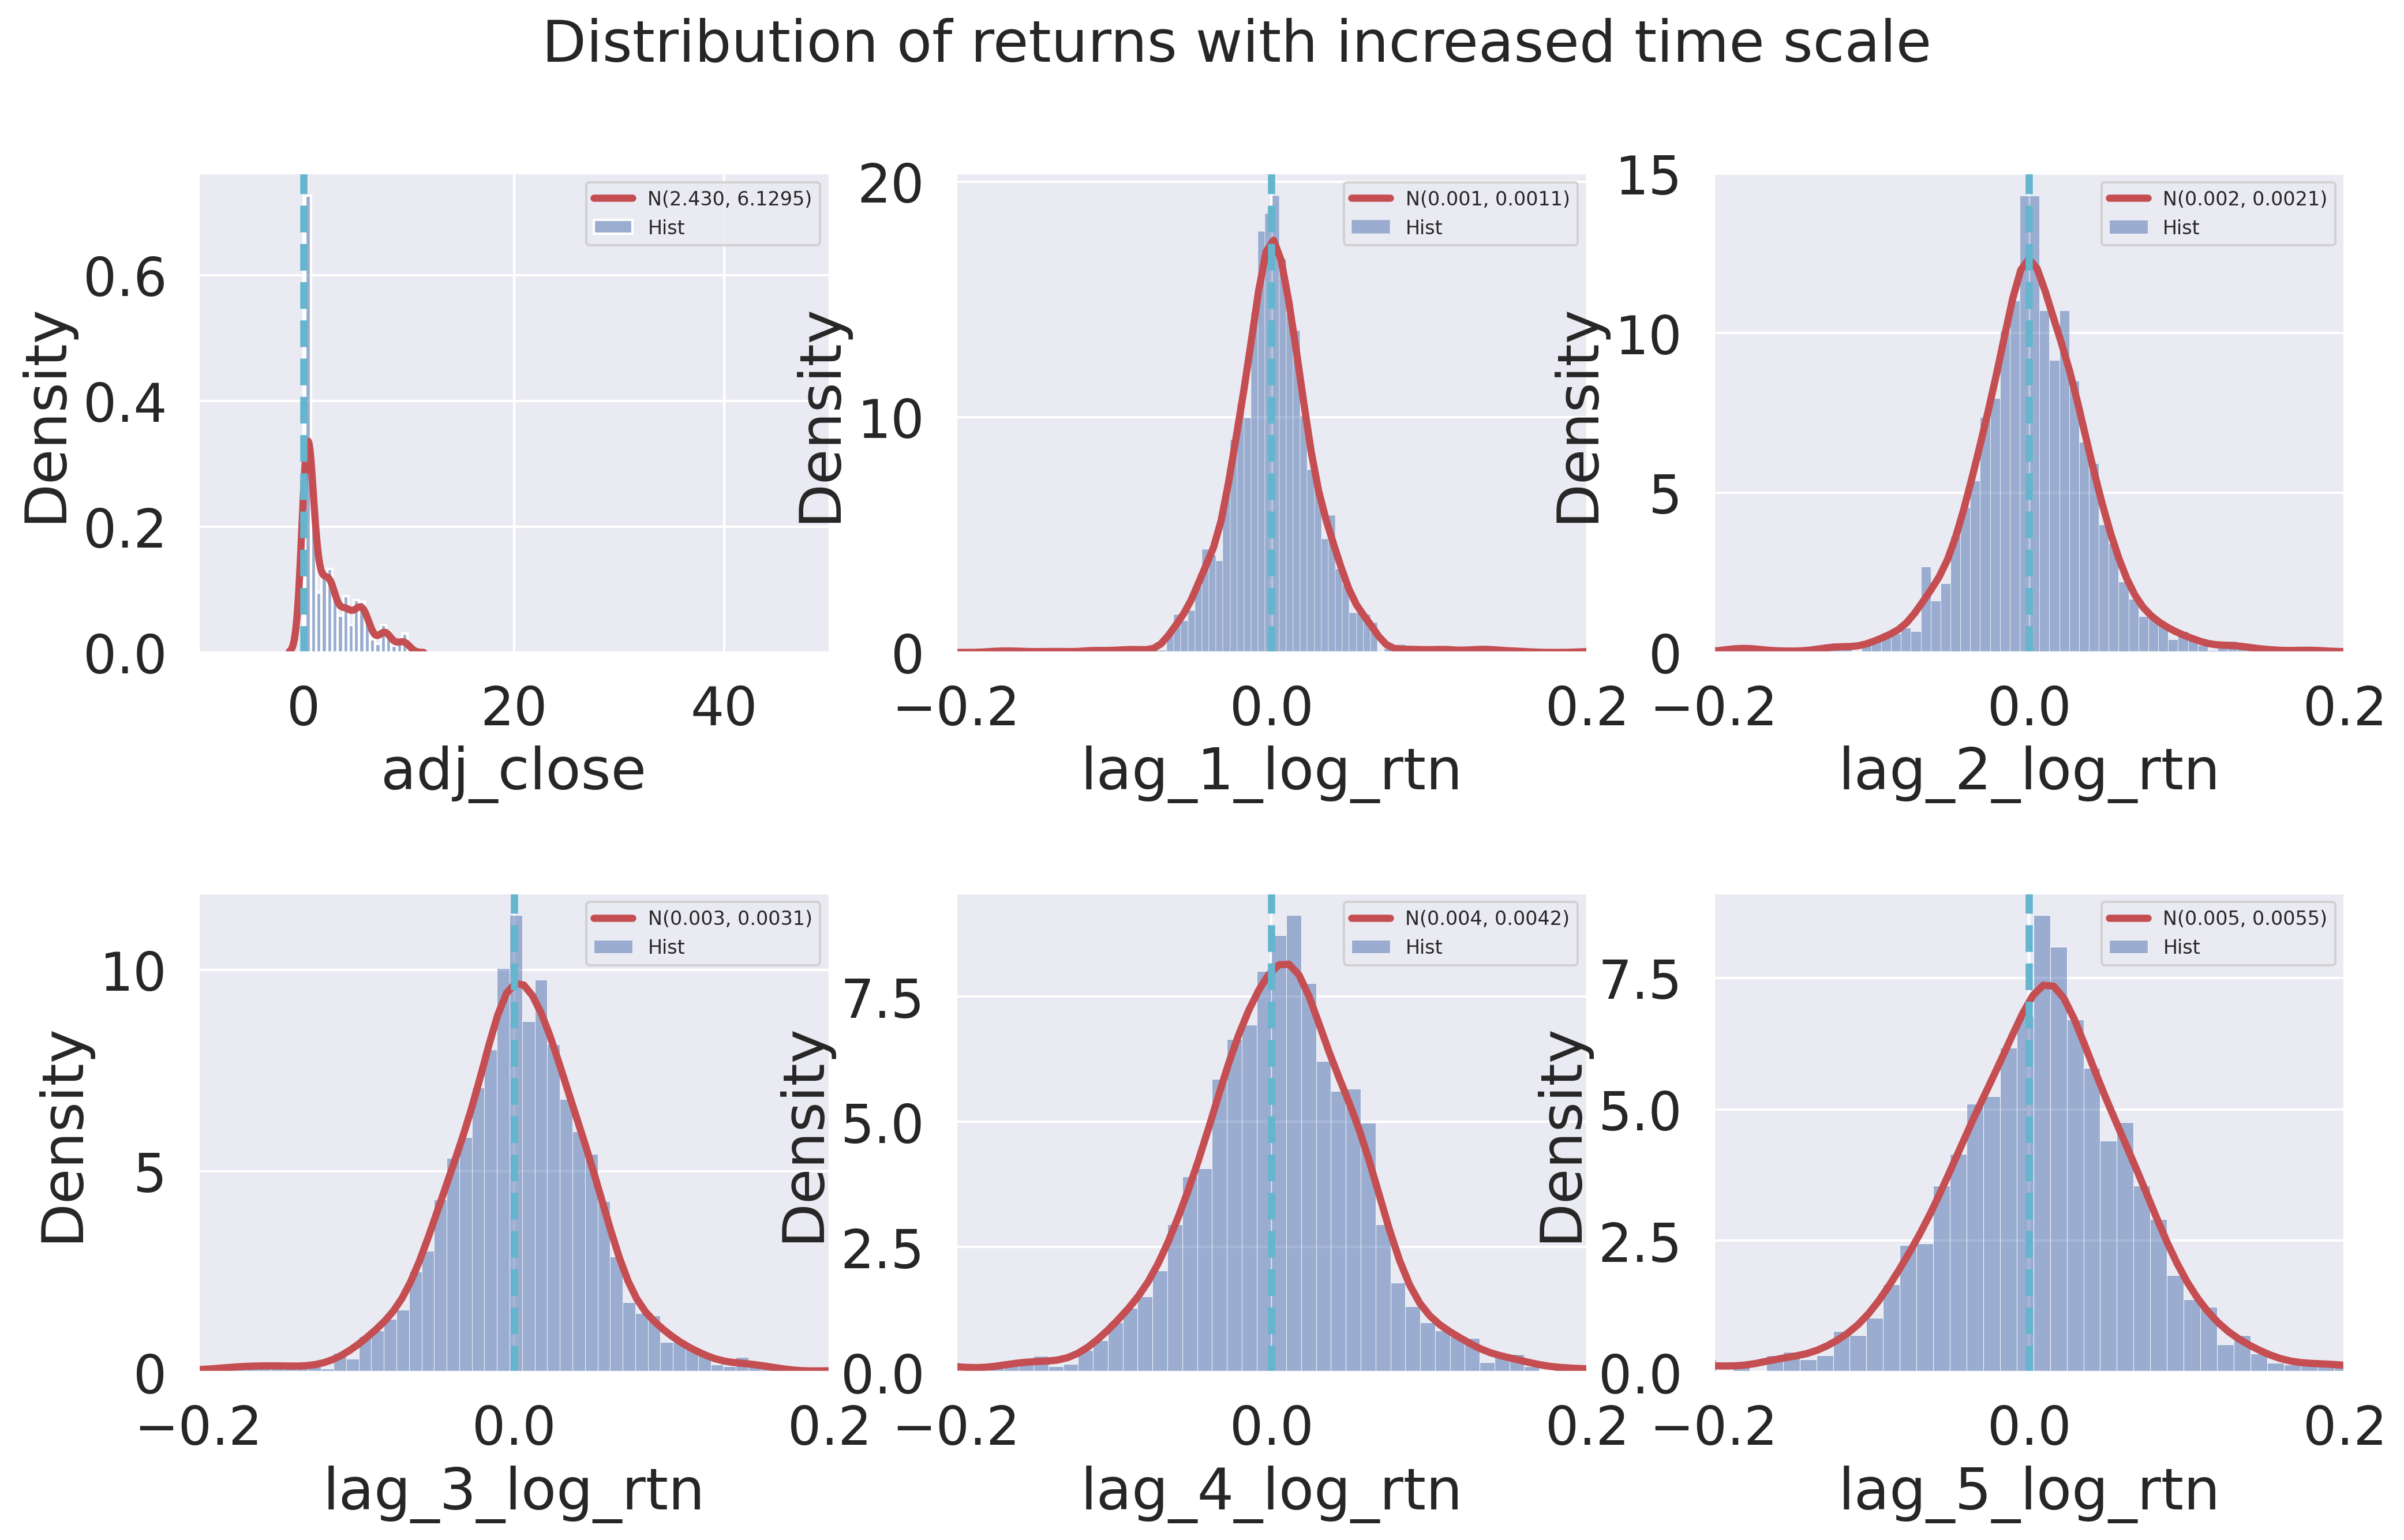

In [19]:
draw_hist_subplots(df_log_rtn)

In [20]:
#using DataFrame to contain all the stats
def build_stats(df):
    stats = pd.DataFrame({'skew':scs.skew(df),
                 'skew_test':scs.skewtest(df)[1],
                 'kurtosis': scs.kurtosis(df),
                 'kurtosis_test' : scs.kurtosistest(df)[1],
                 'normal_test' : scs.normaltest(df)[1]},
                  index = df.columns)
    return stats

In [21]:
build_stats(df_simple_rtn)

,skew,skew_test,kurtosis,kurtosis_test,normal_test
adj_close,1.121395,9.763316e-84,0.322716,2.501323e-03,2.464288e-84
lag_1_simple_rtn,-1.175509,1.924999e-89,30.960369,3.878514e-172,6.602133e-258
lag_2_simple_rtn,-1.190214,5.398841e-91,19.057159,1.230458e-143,5.408078e-231
lag_3_simple_rtn,-1.206750,9.689929e-93,15.042462,1.696531e-129,1.282295e-218
lag_4_simple_rtn,-1.166571,1.688934e-88,13.631952,1.299306e-123,1.632570e-208
lag_5_simple_rtn,-1.184692,2.066260e-90,11.788267,5.770330e-115,8.643691e-202


In [22]:
build_stats(df_log_rtn)

,skew,skew_test,kurtosis,kurtosis_test,normal_test
adj_close,1.121395,9.763316e-84,0.322716,2.501323e-03,2.464288e-84
lag_1_log_rtn,-3.710491,0.000000e+00,85.506956,1.924370e-226,0.000000e+00
lag_2_log_rtn,-3.386655,5.762219e-297,55.148637,4.132602e-204,0.000000e+00
lag_3_log_rtn,-3.361606,5.727173e-295,45.935379,2.815959e-194,0.000000e+00
lag_4_log_rtn,-3.511355,8.388183e-307,44.842506,5.839111e-193,0.000000e+00
lag_5_log_rtn,-3.506838,1.892073e-306,40.490100,2.523984e-187,0.000000e+00


In [23]:
corr_s = df_simple_rtn.corr()
corr_s

,adj_close,lag_1_simple_rtn,lag_2_simple_rtn,lag_3_simple_rtn,lag_4_simple_rtn,lag_5_simple_rtn
adj_close,1.000000,0.016933,0.025926,0.032296,0.037557,0.042414
lag_1_simple_rtn,0.016933,1.000000,0.692282,0.572286,0.505429,0.463920
lag_2_simple_rtn,0.025926,0.692282,1.000000,0.805531,0.706320,0.644687
lag_3_simple_rtn,0.032296,0.572286,0.805531,1.000000,0.859149,0.778582
lag_4_simple_rtn,0.037557,0.505429,0.706320,0.859149,1.000000,0.891210
lag_5_simple_rtn,0.042414,0.463920,0.644687,0.778582,0.891210,1.000000


In [24]:
corr_l = df_log_rtn.corr()
corr_l

,adj_close,lag_1_log_rtn,lag_2_log_rtn,lag_3_log_rtn,lag_4_log_rtn,lag_5_log_rtn
adj_close,1.000000,0.022316,0.032539,0.040052,0.046268,0.051794
lag_1_log_rtn,0.022316,1.000000,0.697586,0.579849,0.516072,0.471812
lag_2_log_rtn,0.032539,0.697586,1.000000,0.811959,0.716690,0.656372
lag_3_log_rtn,0.040052,0.579849,0.811959,1.000000,0.866176,0.789051
lag_4_log_rtn,0.046268,0.516072,0.716690,0.866176,1.000000,0.897758
lag_5_log_rtn,0.051794,0.471812,0.656372,0.789051,0.897758,1.000000


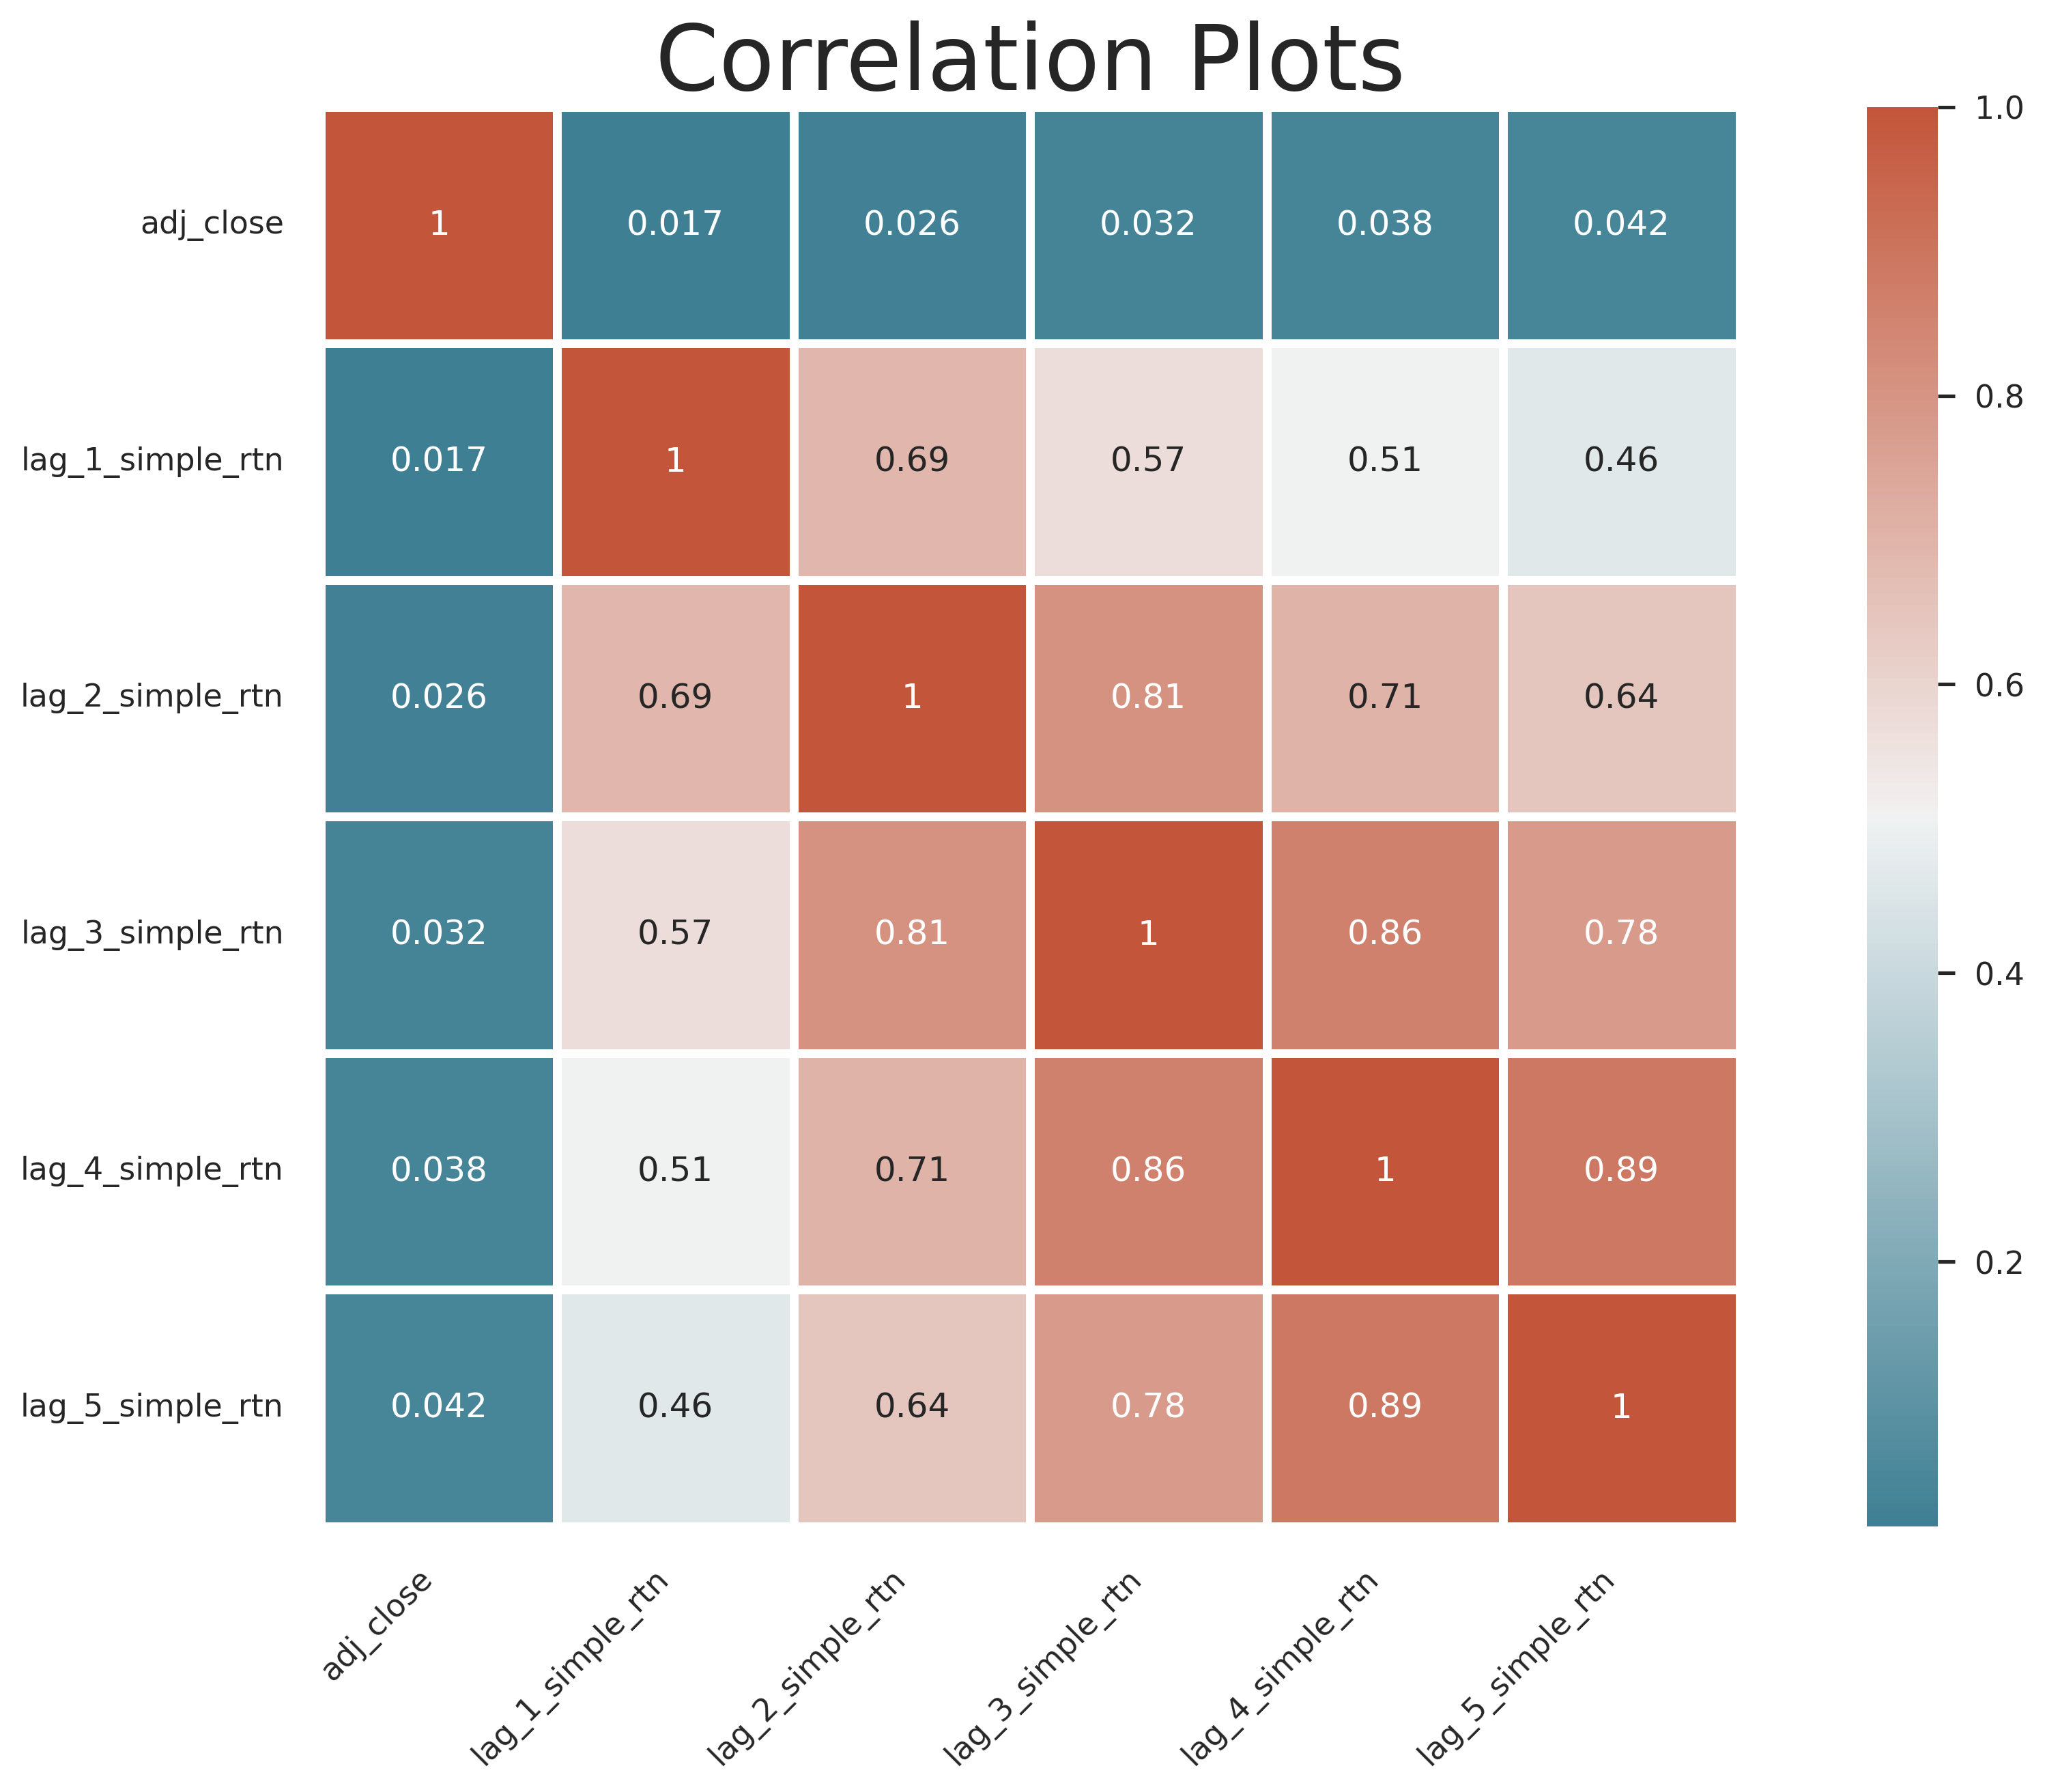

In [25]:
#using seaborne to draw heatmap
sns.set(style="white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr_s, annot=True, cmap=cmap,
                 square=True, linewidths=3,
                 linecolor='w')
ax.set_title('Correlation Plots', fontsize=32)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

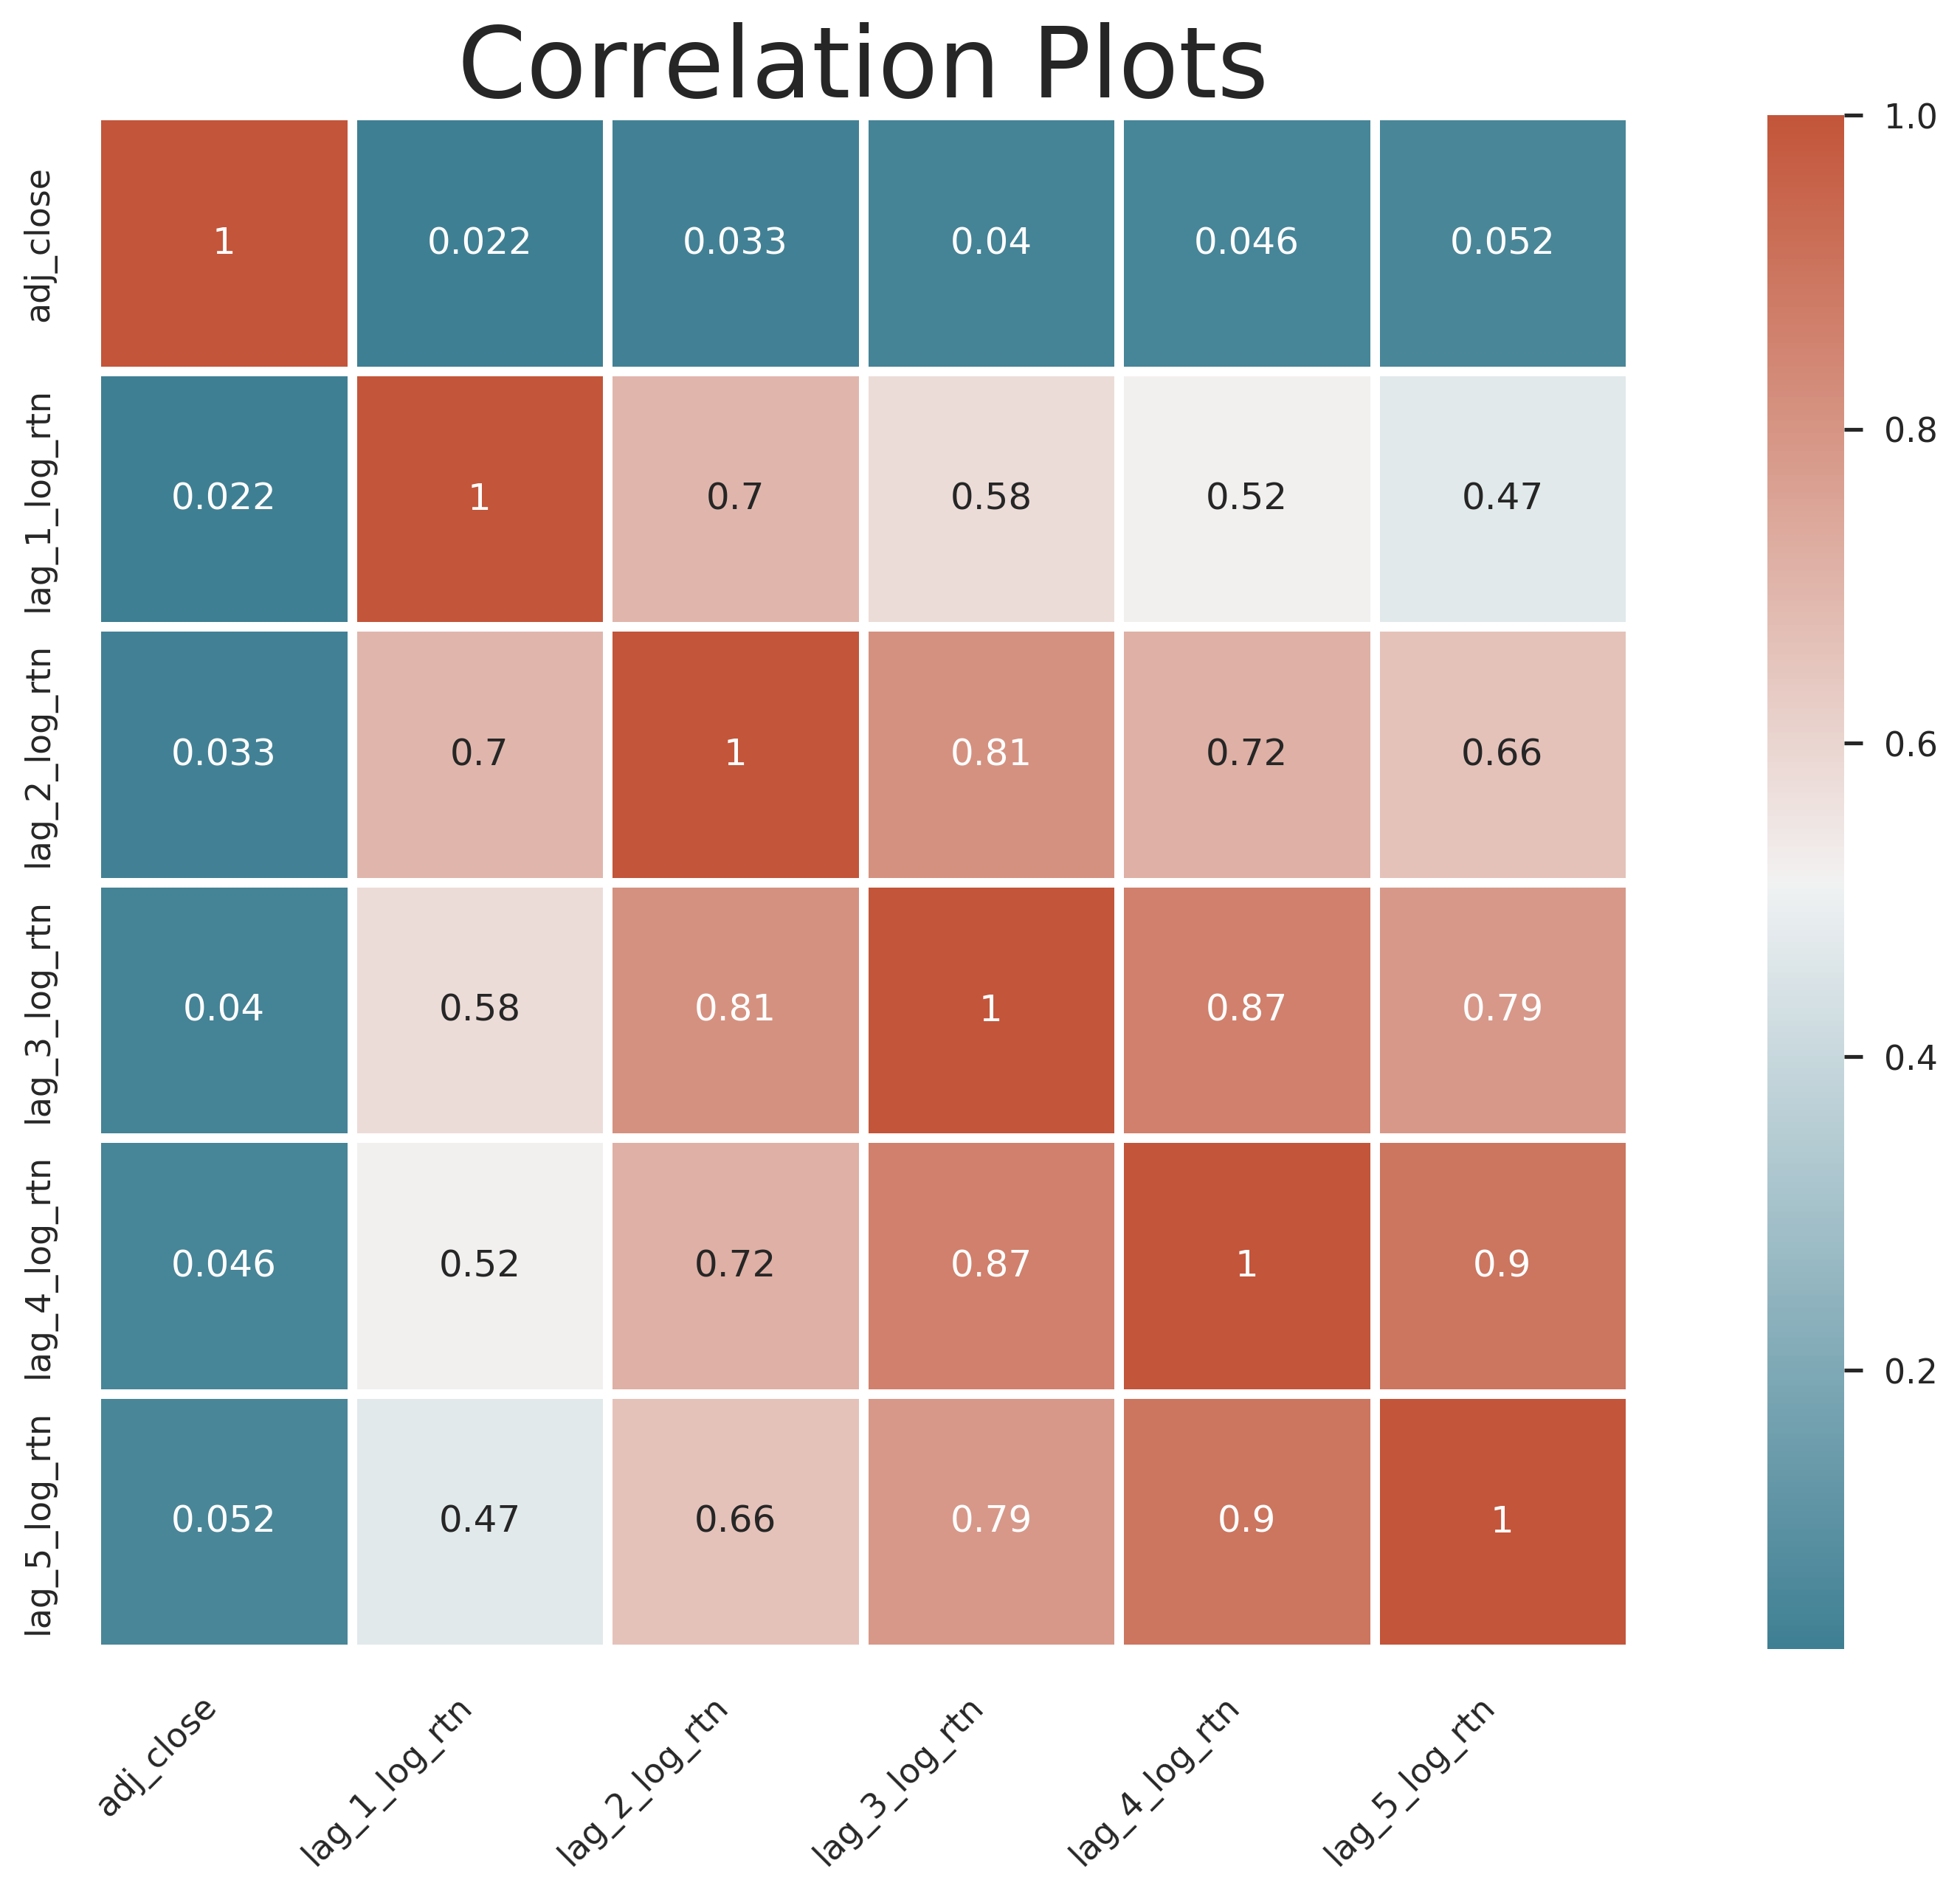

In [28]:
#using seaborne to draw heatmap
sns.set(style="white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr_l, annot=True, cmap=cmap,
                 square=True, linewidths=3,
                 linecolor='w')
ax.set_title('Correlation Plots', fontsize=32)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

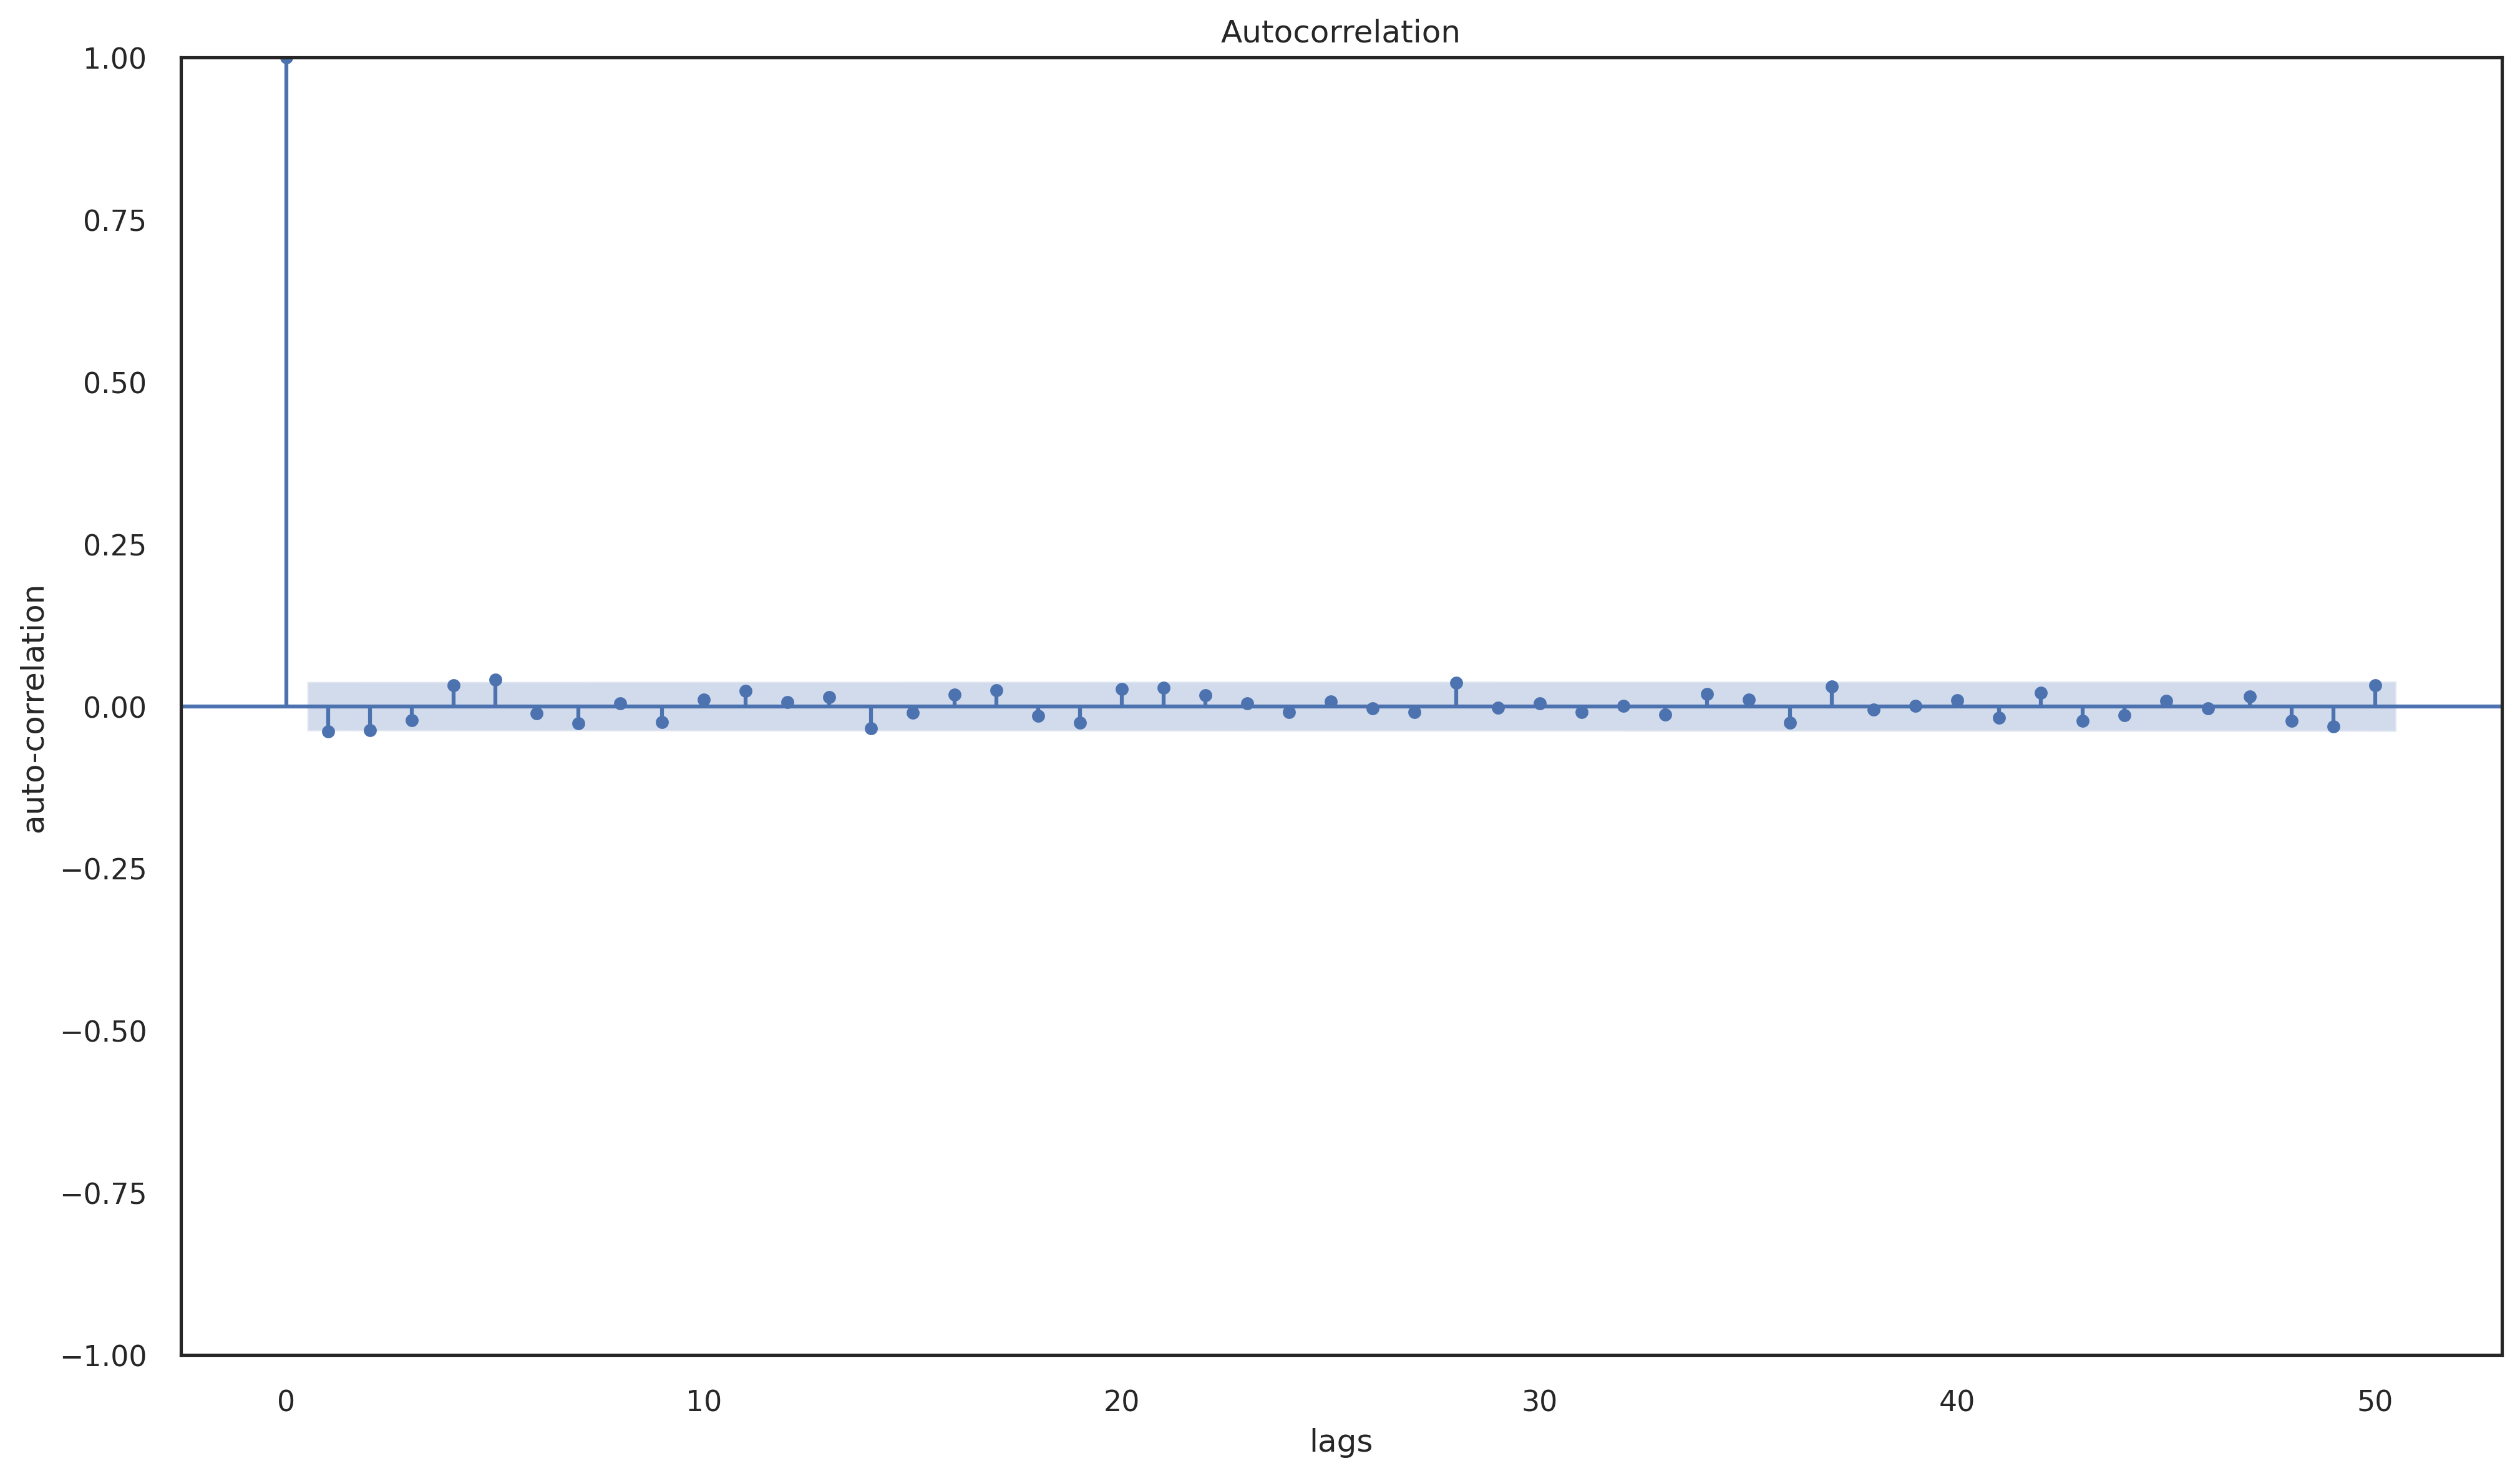

In [27]:
#draw autocorrelation for log return with 50 days time lag
from statsmodels.graphics.tsaplots import plot_acf

d1.dropna(inplace=True)

fig, ax = plt.subplots()
acf = plot_acf(d1.log_rtn, lags=50, ax=ax) 
ax.set_xlabel('lags')                          
ax.set_ylabel('auto-correlation');